Carlos Espeleta<br>
27/11/2019

# Goal

The goal of this task is to predict which new customers are going to purchase additional baggage for their trips using historical from previous customers. The code can be developed in any of the following languages: R, Python or Java.

# Data Description
The data fields are the following ones:
* **TIMESTAMP**: (*date*) Date when the booking was bought.
* **WEBSITE**: (*string*) Website where the trip was purchased. It is composed of a prefix that stands for the website (“ED” = Edreams, “OP” = Opodo, “GO” = Go Voyage) and a suffix for the country (for example: ES = Spain)
* **GDS**: (*integer*) Number of flights bought through the Global Distribution System
* **NO GDS**: (*integer*) Number of flights bought though other channels.
* **DEPARTURE**: (*date*) Departure date
* **ARRIVAL**: (*date*) Arrival date
* **ADULTS**: (*integer*) Number of adults
* **CHILDREN**: (*integer*) Number of children
* **INFANTS**: (*integer*) Number of infants
* **TRAIN**: (*boolean*) Whether the booking contains train tickets or not
* **DISTANCE**: (*float*) Distance travelled
* **DEVICE**: (*string*) Device used for the purchase
* **HAUL TYPE** (*string*): Whether the trip was “Domestic”, “Continental” or “Intercontinental”.
* **TRIP TYPE**: (*string*) Trips can be either “One Way”, “Round Trip” or “Multi-Destination”
* **PRODUCT**: (*string*) Bookings can contain only travel (“Trip”) or the travel and a hotel (“Dynpack”).
* **SMS**: (*boolean*) Indicates if the customer has selected a confirmation by SMS
* **EXTRA BAGGAGE**: (*boolean*) Variable to predict, only in the train dataset. Indicates if the customer has purchased extra baggage for the trip or not.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, auc
from sklearn.metrics import precision_recall_curve

import lightgbm as lgb
from tqdm.notebook import tqdm
from scipy import stats

import category_encoders as ce
import itertools as it
import os

# Any results you write to the current directory are saved as output.
TARGET = 'EXTRA_BAGGAGE'

In [2]:
dtypes = {
    'WEBSITE':       'category', # object,
    'GDS':           np.int8,    # 'category'
    'NO_GDS':        np.int8,    # 'category'
    'DEPARTURE':     object,
    'ARRIVAL':       object,
    'ADULTS':        np.int8,    # 'category', 
    'CHILDREN':      np.int8,    # 'category', 
    'INFANTS':       np.int8,    # 'category', 
    'TRAIN':         bool,
    'DISTANCE' :     float,
    'DEVICE':        'category',
    'HAUL_TYPE':     'category', 
    'TRIP_TYPE':     'category',
    'PRODUCT':       'category',
    'SMS':           bool,
    'EXTRA_BAGGAGE': bool
}
path = '../input/edreams'

In [3]:
train = pd.read_csv(f'{path}/train.csv', sep=';', index_col='ID', decimal=',', dtype=dtypes)
test  = pd.read_csv(f'{path}/test.csv', sep=';', index_col='ID', decimal=',', dtype=dtypes)
train.head()

,TIMESTAMP,WEBSITE,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,EXTRA_BAGGAGE,NO_GDS
ID,,,,,,,,,,,,,,,,,
0,01/July,EDES,1,22/July,25/July,1,0,0,False,DOMESTIC,628.844,TABLET,ROUND_TRIP,TRIP,True,False,0
1,01/July,EDIT,0,29/July,29/July,1,0,0,False,CONTINENTAL,1281.430,SMARTPHONE,ONE_WAY,TRIP,False,False,1
2,01/July,OPUK,2,29/July,19/August,1,0,0,False,CONTINENTAL,1730.350,TABLET,ROUND_TRIP,TRIP,True,False,0
3,01/July,OPIT,0,24/July,04/August,1,0,0,False,DOMESTIC,652.702,SMARTPHONE,MULTI_DESTINATION,TRIP,False,False,2
4,01/July,EDES,0,11/August,11/August,1,0,0,False,CONTINENTAL,1717.850,COMPUTER,ONE_WAY,TRIP,False,False,1


In [4]:
# Re-order categories
train['HAUL_TYPE'].cat.set_categories(['DOMESTIC', 'CONTINENTAL', 'INTERCONTINENTAL'], ordered=True, inplace=True)
train['TRIP_TYPE'].cat.set_categories(['ONE_WAY', 'ROUND_TRIP', 'MULTI_DESTINATION'], ordered=True, inplace=True)

# Make sure each category is encoded as in the Train set
for c in train.select_dtypes('category').columns:
    test[c].cat.set_categories(train[c].cat.categories, ordered=True, inplace=True)

In [5]:
print(f'Train: {train.shape[0]} rows x {train.shape[1]} columns\n'
      f'Test:  {test.shape[0]} rows x {test.shape[1]} columns')

# Check that the extra column is the target
print(f'\nColumns that exist on Train but not in Test:\n'
      f'{set(train.columns) - set(test.columns)}')

Train: 50000 rows x 17 columns
Test:  30000 rows x 16 columns

Columns that exist on Train but not in Test:
{'EXTRA_BAGGAGE'}


One of the easiest ways of partitioning data in competitions (or test like this one) is use `TIMESTAMP` to not introduce leakeage. 

In [6]:
# Date ranges
print(f'Train timestamp: {train["TIMESTAMP"].unique()}\n'
      f'Test timestamp:  {test["TIMESTAMP"].unique()}')

Train timestamp: ['01/July' '02/July']
Test timestamp:  ['03/July' '04/July']


In [7]:
# Store in an array the original features
base_features = train.columns.drop([TARGET, 'TIMESTAMP']).intersection(test.columns)
print(base_features)

Index(['WEBSITE', 'GDS', 'DEPARTURE', 'ARRIVAL', 'ADULTS', 'CHILDREN',
       'INFANTS', 'TRAIN', 'HAUL_TYPE', 'DISTANCE', 'DEVICE', 'TRIP_TYPE',
       'PRODUCT', 'SMS', 'NO_GDS'],
      dtype='object')


## Missing values

This data set contains few missing values and all of them belongs to the `DEVICE` feature. I noticed that this missing values exist in both train and test sets. For the train set we can either remove those rows because the missing values represents only the 0.26% of the values or impute them. Regarding the imputation there are different ways to do that, such replace them by a new category (missign, NA, etc.), use the most frequent device or create a model to predict the missing values.

In [8]:
def n_missing(df, thr=None):
    x = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
    return x if thr is None else list(x[x >= thr].index)

pd.concat([n_missing(train), n_missing(test)], axis=1, 
          sort=False, keys=['Train', 'Test'])

,Train,Test
DEVICE,0.00266,0.001733
NO_GDS,0.00000,0.000000
INFANTS,0.00000,0.000000
WEBSITE,0.00000,0.000000
GDS,0.00000,0.000000
DEPARTURE,0.00000,0.000000
ARRIVAL,0.00000,0.000000
ADULTS,0.00000,0.000000
CHILDREN,0.00000,0.000000
TRAIN,0.00000,0.000000


## Unique values

In case that would exist features with just 1 value they should be removed because as they don't have variance they don't provide anything to our models. Most of the categories have the same number of unique values which is good because this means that the same data is present in both train and test.

In [9]:
def n_unique(df, thr=None):
    x = df.nunique().sort_values(ascending=False)
    return x if thr is None else list(x[x <= thr].index)

pd.concat([n_unique(train), n_unique(test)], axis=1, 
          sort=False, keys=['Train', 'Test'])

,Train,Test
DISTANCE,10648,8171.0
ARRIVAL,347,329.0
DEPARTURE,333,314.0
WEBSITE,60,58.0
ADULTS,10,10.0
CHILDREN,6,5.0
NO_GDS,5,5.0
GDS,5,5.0
DEVICE,4,4.0
TRIP_TYPE,3,3.0


From the following output we can can see how all the categories present in the train data are also present in the test. However, we can see how there are two `WEBSITES` (OPFRC, OPPL) that just exist in the train set and the same happens with `CHILDREN` = 5

In [10]:
{col: set(train[col].unique()).symmetric_difference(test[col].unique())
 for col in base_features.drop(['DEPARTURE', 'ARRIVAL', 'DISTANCE'])}

{'WEBSITE': {'OPFRC', 'OPPL'},
 'GDS': set(),
 'ADULTS': set(),
 'CHILDREN': {5},
 'INFANTS': set(),
 'TRAIN': set(),
 'HAUL_TYPE': set(),
 'DEVICE': set(),
 'TRIP_TYPE': set(),
 'PRODUCT': set(),
 'SMS': set(),
 'NO_GDS': set()}

In [11]:
# Remove this rows
tmp = train.query('WEBSITE in ["OPFRC", "OPPL"]')
print(f'There are {len(tmp)} rows of WEBSITE in ["OPFRC", "OPPL"]')
tmp = train.query('CHILDREN == 5')
print(f'There are {len(tmp)} rows of CHILDREN == 5')
del tmp

There are 2 rows of WEBSITE in ["OPFRC", "OPPL"]
There are 1 rows of CHILDREN == 5


In [12]:
col = 'DISTANCE'
n = len(list(set(train[col].unique()).symmetric_difference(test[col].unique())))
print(f'There are {n} DISTANCES that exist both in TRAIN and TEST')
n = len(list(set(train[col].unique()).difference(test[col].unique())))
print(f'There are {n} DISTANCES that exist in TRAIN but not in TEST')
n = len(list(set(test[col].unique()).difference(train[col].unique())))
print(f'There are {n} DISTANCES that exist in TEST but not in TRAIN')

There are 8151 DISTANCES that exist both in TRAIN and TEST
There are 5314 DISTANCES that exist in TRAIN but not in TEST
There are 2837 DISTANCES that exist in TEST but not in TRAIN


## Repated values

Exist some variables in which the same element is repeated most of the time, for instance, in `TRAIN` 99,46% of the time we have the value `0`. We can think of remove this variables because they doesn't have enought variability but on the other hand they can interact with other variables and provide us good insights.

In [13]:
def mode(df, thr=None):
    x = df.apply(lambda x: x.value_counts(dropna=False, normalize=True).values[0]
                ).sort_values(ascending=False)
    return x if thr is None else list(x[x >= thr].index)

pd.concat([mode(train), mode(test)], axis=1, 
          sort=False, keys=['Train', 'Test'])

,Train,Test
TRAIN,0.99462,0.994567
INFANTS,0.98214,0.980767
PRODUCT,0.98088,0.980300
CHILDREN,0.92722,0.928333
EXTRA_BAGGAGE,0.80402,NaN
TIMESTAMP,0.75644,0.777433
DEVICE,0.68128,0.681267
ADULTS,0.64422,0.603600
TRIP_TYPE,0.61008,0.617633
GDS,0.53694,0.557433


## Duplicated rows

There are some rows of this data set that are duplicated. As I don't have the timestamp with minutes and seconds I cannot say that they are duplicates.

In [14]:
mask = train.duplicated(keep=False)
print(f'There are {int(mask.sum()/2)} duplicated rows')
train[mask].sort_values(by=train.columns.to_list()).head(6)

There are 2092 duplicated rows


,TIMESTAMP,WEBSITE,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,EXTRA_BAGGAGE,NO_GDS
ID,,,,,,,,,,,,,,,,,
10428,01/July,EDAE,0,06/August,06/August,2,2,0,False,CONTINENTAL,1113.040,COMPUTER,ONE_WAY,TRIP,False,True,1
15514,01/July,EDAE,0,06/August,06/August,2,2,0,False,CONTINENTAL,1113.040,COMPUTER,ONE_WAY,TRIP,False,True,1
1279,01/July,EDAE,1,02/September,02/September,1,0,0,False,INTERCONTINENTAL,4490.270,COMPUTER,ONE_WAY,TRIP,False,False,0
16553,01/July,EDAE,1,02/September,02/September,1,0,0,False,INTERCONTINENTAL,4490.270,COMPUTER,ONE_WAY,TRIP,False,False,0
2871,01/July,EDAE,1,03/July,08/July,1,0,0,False,DOMESTIC,147.613,COMPUTER,ROUND_TRIP,TRIP,False,False,0
13447,01/July,EDAE,1,03/July,08/July,1,0,0,False,DOMESTIC,147.613,COMPUTER,ROUND_TRIP,TRIP,False,False,0


In [15]:
train = train.drop_duplicates(keep='first')

## Rows intersection
There are rows in both datasets that are completely equal. We could use the target of the train to get the predictions of the test.

In [16]:
# Rows intersection
s1 = pd.merge(train[base_features], test[base_features], how='inner', 
              on=test[base_features].columns.to_list())
print(f'There are {len(s1)} rows that intersect')
s1.head()

There are 342 rows that intersect


,WEBSITE,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,NO_GDS
0,EDES,1,05/July,05/July,1,0,0,False,DOMESTIC,202.221,COMPUTER,ONE_WAY,TRIP,False,0
1,EDES,0,03/July,03/July,2,0,0,True,INTERCONTINENTAL,0.000,TABLET,ONE_WAY,TRIP,True,1
2,OPDEC,0,04/July,05/July,1,0,0,False,DOMESTIC,470.846,OTHER,ROUND_TRIP,TRIP,True,1
3,EDJP,1,01/September,21/September,9,0,0,False,CONTINENTAL,5901.450,COMPUTER,ROUND_TRIP,TRIP,False,0
4,GOFR,0,24/August,24/August,1,0,0,False,INTERCONTINENTAL,9102.630,SMARTPHONE,ONE_WAY,TRIP,True,1


## Dates
The data set comes with three date variables (`TIMESTAMP`, `DEPARTURE`, `ARRIVAL`) as strings. As I don't have information about the year, I will use 2017 as a default. Some fixes has been done:
* If `DEPARTURE` < `ARRIVAL` then `ARRIVAL` = `ARRIVAL` + 1 year
* If `DEPARTURE` < `TIMESTAMP` then: <br><br>
    * `DEPARTURE` = `DEPARTURE` + 1 year<br>
    * `ARRIVAL` = `ARRIVAL` + 1 year

In [17]:
def fix_dates(df, cols=['TIMESTAMP', 'DEPARTURE', 'ARRIVAL']):
    df = df.copy()
    for col in cols:
        df[col] = pd.to_datetime((df[col] +'/2017').str.replace('-', '/'), format='%d/%B/%Y')
    
    # If arrival < departure -> add 1 year to arrival
    mask = df['ARRIVAL'] < df['DEPARTURE']
    df.loc[mask, 'ARRIVAL'] = (df.loc[mask, 'ARRIVAL'] + pd.offsets.DateOffset(years=1)).dt.normalize()
    
    # If timestamp < arrival -> extract 1 year to timestamp
    mask = df['DEPARTURE'] < df['TIMESTAMP']
    df.loc[mask, 'DEPARTURE'] = (df.loc[mask, 'DEPARTURE'] + pd.offsets.DateOffset(years=1)).dt.normalize()
    df.loc[mask, 'ARRIVAL'] = (df.loc[mask, 'ARRIVAL'] + pd.offsets.DateOffset(years=1)).dt.normalize()
    return df

In [18]:
# Convert strings to dates
train = fix_dates(train)
test = fix_dates(test)

## Adding variables

A first pre-process is done and the following variables have been ceated:

* **Split WEBSITE** into WEB and COUNTRY
* **DAYS_TO_FLIGHT**: number of days between the booking and the departure
* **TRIP_DAYS**: Number of days will take the trip
* **IS_SAME_DAY**: The traveler goes and come back in the same day
* Day, Month and Quarter of Departure
* **PASSENGERS**: Total number of passenger (adult + children + infants)
* **ADULTS_RATIO**: Number of adults / total passengers
* **TOTAL_FLIGHTS**: Sum of all the flights bought through GDS and NO_GDS

In [19]:
def proc_df(df):
    # Split WEBSITE into WEB and CC
    df['WEB'] = df['WEBSITE'].str.slice(0, 2).astype('category')
    df['COUNTRY'] = df['WEBSITE'].str.slice(2, 4).astype('category')
    # df.drop('WEBSITE', axis=1, inplace=True)
    # Append date features
    df['DAYS_TO_FLIGHT'] = (df['DEPARTURE'] - df['TIMESTAMP']).dt.days
    df['TRIP_DAYS'] = (df['ARRIVAL'] - df['DEPARTURE']).dt.days
    df['IS_SAME_DAY'] = (df['TRIP_TYPE'] == 'ROUND_TRIP') & (df['TRIP_DAYS'] == 0)
    df['DEP_D'] = df['DEPARTURE'].dt.day#.astype('category')          #.astype(np.int8)
    months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December']
    df['DEP_M'] = df['DEPARTURE'].dt.month_name() #.astype(np.int8)
    df['DEP_M'] = pd.Categorical(df['DEP_M'], categories=months_order, ordered=True)
    df['DEP_Q'] = df['DEPARTURE'].dt.quarter.astype('category')      #.astype(np.int8)
    # Total number of passengers
    df['PASSENGERS'] = (df['ADULTS'] + df['CHILDREN'] + df['INFANTS']).astype(np.int8)
    df['ADULTS_RATIO'] = (df['ADULTS'] / df['PASSENGERS']).astype(np.float32)
    df['CHILDREN_RATIO'] = (df['CHILDREN'] / df['PASSENGERS']).astype(np.float32)
    df['INFANTS_RATIO'] = (df['INFANTS'] / df['PASSENGERS']).astype(np.float32) # Makes sense? Is not possible to travel 1 INFANT alone..
    # Total flights
    df['TOTAL_FLIGHTS'] = df['GDS'] + df['NO_GDS']
    #df['GDS_RATIO'] = df['GDS'] / df['NO_GDS']
    #df['GDS_RATIO'][df['GDS_RATIO'] == np.inf] = 0
    return df

In [20]:
# Process data frame
train = proc_df(train)
test  = proc_df(test)

# Filter out rows with train data only
train = train.query('(WEBSITE not in ["OPFRC", "OPPL"]) & (CHILDREN != 5)')
train['WEBSITE'].cat.remove_categories(['OPFRC', 'OPPL'], inplace=True)

# Store timestamp to create train and validation indexes
timestamp = train['TIMESTAMP'].values
timestamp_test = test['TIMESTAMP'].values

# Drop Timestamp
train.drop('TIMESTAMP', axis=1, inplace=True)
test.drop('TIMESTAMP', axis=1, inplace=True)

# Target

The target is distributed as follows: 80% of the samples don't have bought an extra baggage while 20% have bought it.

In [21]:
# Imbalanced dataset
train[TARGET].value_counts() / len(train)

False    0.802793
True     0.197207
Name: EXTRA_BAGGAGE, dtype: float64

Most of the departures are between July and August

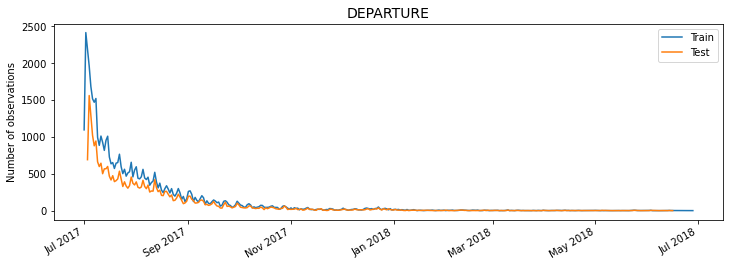

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
train['DEPARTURE'].dt.floor('D').value_counts().sort_index().plot(
    ax=ax).set_xlabel('')
test['DEPARTURE'].dt.floor('D').value_counts().sort_index().plot(
    ax=ax).set_ylabel('Number of observations')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title('DEPARTURE', fontsize=14)
ax.legend(['Train', 'Test'])
plt.show()

Flights with departure on week 25 and 26 exist in the training data but not in the test data

In [23]:
col = 'DEPARTURE'
set(train[col].dt.week.unique()) - set(test[col].dt.week.unique())

{25, 26}

## Seasonality

* **Day of month**: There is a little uptrend as the day of the month goes on.
* **Day of week**: Departures at the beginning of the week are more likely to buy an extra baggage. Business travalers usually take flights at the beginning of the week and then come back at the end of the week. As they are not paying their tickets (because of work) maybe they expend more money in the ticket?
* **Month**: People usually buy an extra baggage in february and in August. This may be because winter clothes take up more space in the suitcase. 

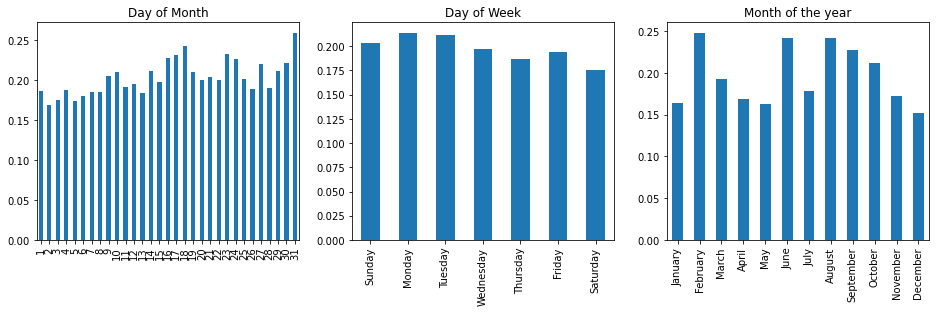

In [24]:
# Seasonality ? Que dia de la semana se hacen mas registros?
f, ax = plt.subplots(1, 3, figsize=(16, 4))
train.groupby(train['DEPARTURE'].dt.day)[TARGET].mean().plot(kind='bar', ax=ax[0]).set_title('Day of Month')
days = ['Sunday', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
train.groupby(train['DEPARTURE'].dt.day_name())[TARGET].mean().reindex(days).plot(kind='bar', ax=ax[1]).set_title('Day of Week')
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
train.groupby(train['DEPARTURE'].dt.month_name())[TARGET].mean().reindex(months).plot(kind='bar', ax=ax[2]).set_title('Month of the year')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
plt.show()

## Train

In [25]:
exclude = [TARGET, 'DEPARTURE', 'ARRIVAL', 'DISTANCE', 
           'ADULTS_RATIO', 'CHILDREN_RATIO', 'INFANTS_RATIO', 
           'TRIP_DAYS', 'DAYS_TO_FLIGHT']
cat_cols = train.columns.drop(exclude)
np.asarray(cat_cols)

array(['WEBSITE', 'GDS', 'ADULTS', 'CHILDREN', 'INFANTS', 'TRAIN',
       'HAUL_TYPE', 'DEVICE', 'TRIP_TYPE', 'PRODUCT', 'SMS', 'NO_GDS',
       'WEB', 'COUNTRY', 'IS_SAME_DAY', 'DEP_D', 'DEP_M', 'DEP_Q',
       'PASSENGERS', 'TOTAL_FLIGHTS'], dtype=object)

In the following plot we see in orange the percentage of positive `EXTRA_BAGGAGE` and in blue the negatives ones. This chart is showing us those categories that are more likely to buy and extra baggage:

Some of the most important things to highlight are:

* While `GDS` does not seem to provide anythng to our analysis `NO_GDS` seems to be a good predictor because as the number increases the probability does to. The same happens with `TOTAL_FLIGHTS`.
* `ADULTS` that travel in groups (up to 6) are more likely to buy an extra baggage,
* `PRODUCT`, `SMS`, `WEB`, `Departure day` and `Departure quarter` doesn't seems to provide much information.

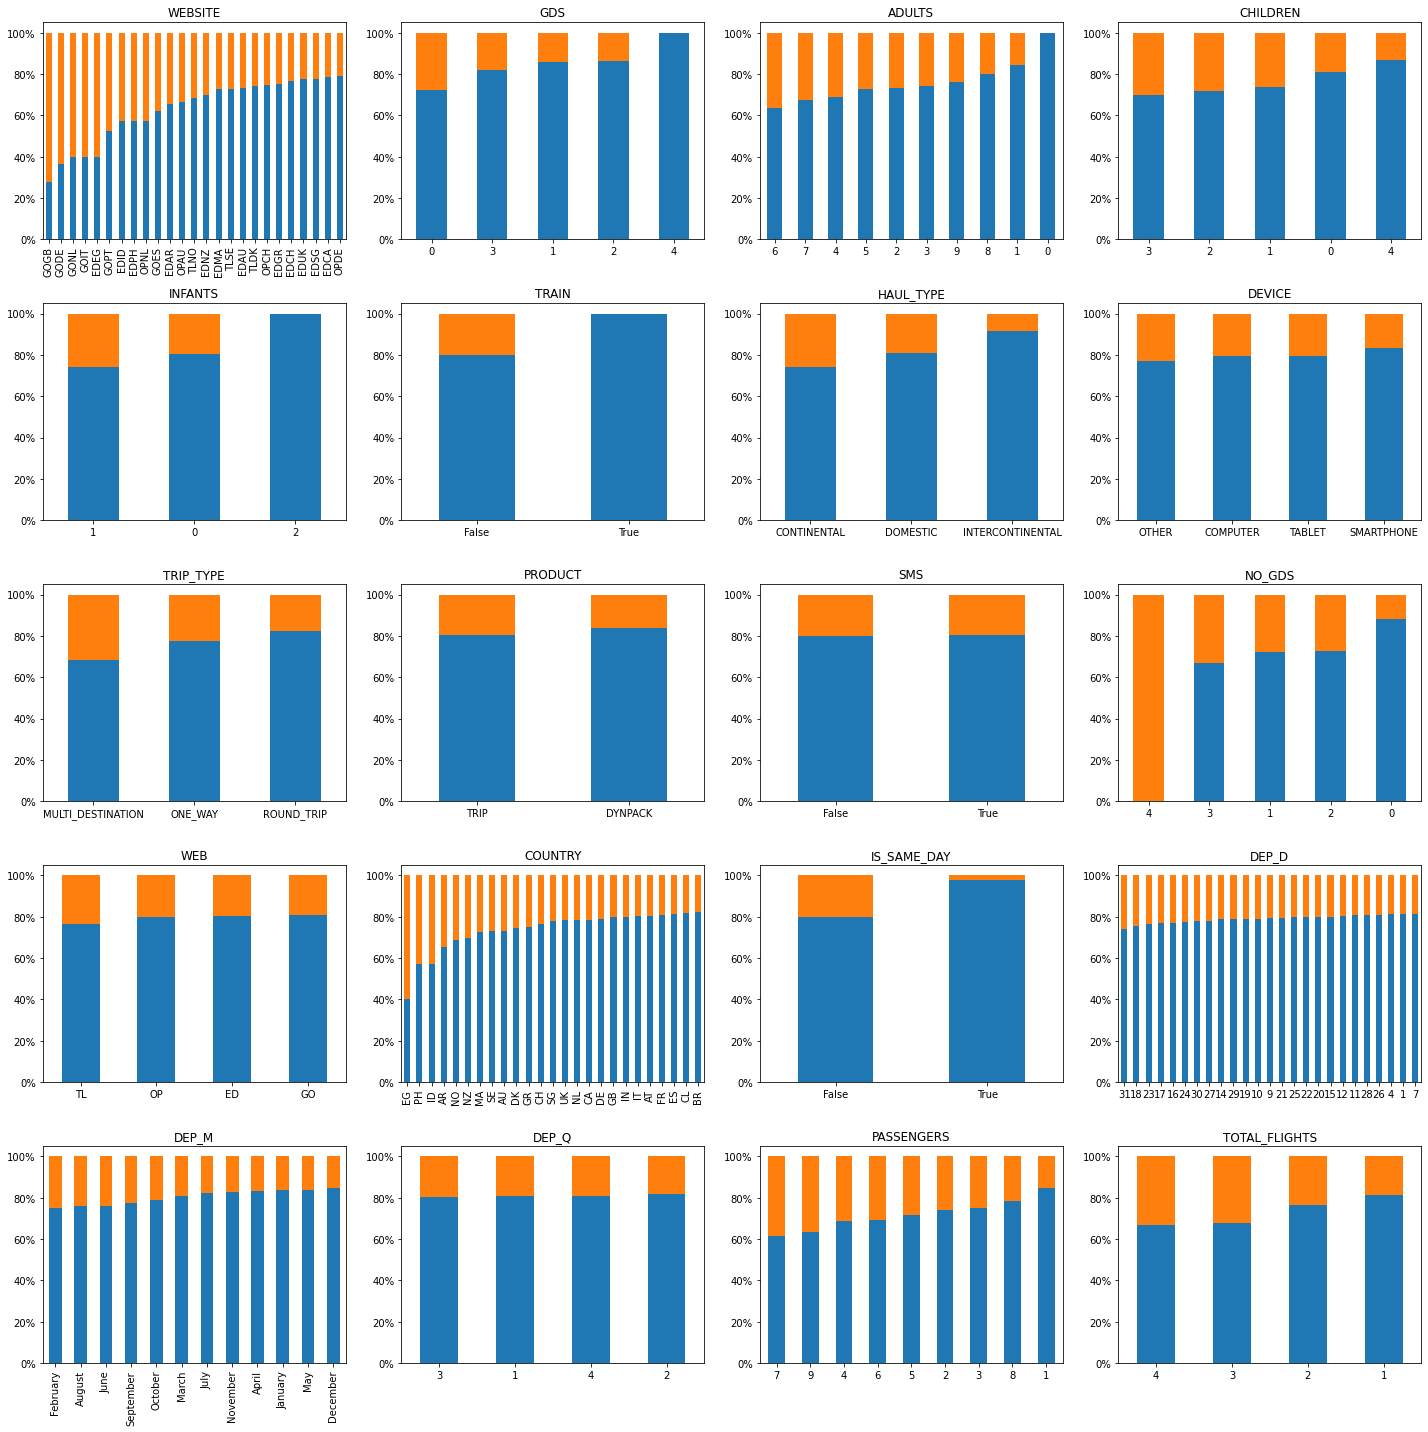

In [26]:
def plot_props(train, cols, nc=3, show_max=25):
    nr = (len(cols) // nc) #+ 1
    f, axes = plt.subplots(nr, nc, figsize=(max(nc*5, 20), 4*nr))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        props = train.groupby(col)[TARGET].value_counts(
            normalize=True).unstack().fillna(0).sort_values(by=True, ascending=False)[:show_max]
        _ = props.plot(kind='bar', stacked='True', ax=axes[i])
        _.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        _.set_title(col)
        _.set_ylabel('')
        _.set_xlabel('')
        if col not in ['WEBSITE', 'COUNTRY', 'DEP_W', 'DEP_M']: 
            plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=0)
        axes[i].legend_.remove()
    plt.tight_layout()
    
# Plot proportions
plot_props(train, cat_cols, nc=4)

So far we have seen that, for instance, travelers with `NO_GDS` = 4 will buy an extra baggage. But, how many observations we have in this category? Is this number realiable? It is possible that we just have one observation in this category (`NO_GDS` = 4). To answer this question I have created another visualization that let us take a look to all of this metrics.

## Train vs Test

What would happen if we had a very predictive feature in the train set but has no presence (or completely different distribution) in the test set? In that case this predictor will become worthless. For that reason with the following plot we are going to check that the train and test have similar distributions (using counts / percentages).

In the left axis we can see the percentage of samples that corresponds to one category and in the right axis we have the probability to buy an extra baggage.

For example:

* France and Spain are the most representative countries with 30% and 15% of samples respectively. Both countries have ~18% of buy an extra baggage.
* There are many countries with very few observations. All these countries can be encapsulated in a new category.
* 60% of the `ADULTS` travel alone and 30% in couples.
* There are just few observation that have booked a train
* There are as twice as continental flights than intercontinental or domestic. Intercontinental flights are less likely to buy an extra baggage and this may be due to intercontinental flights already include baggage whereas the continental and domestic flights does not.
* Most of the reservations have been done through computer. When the reservation is done using mobile phones the probability to buy an extra baggage decreases up to ~ 5%

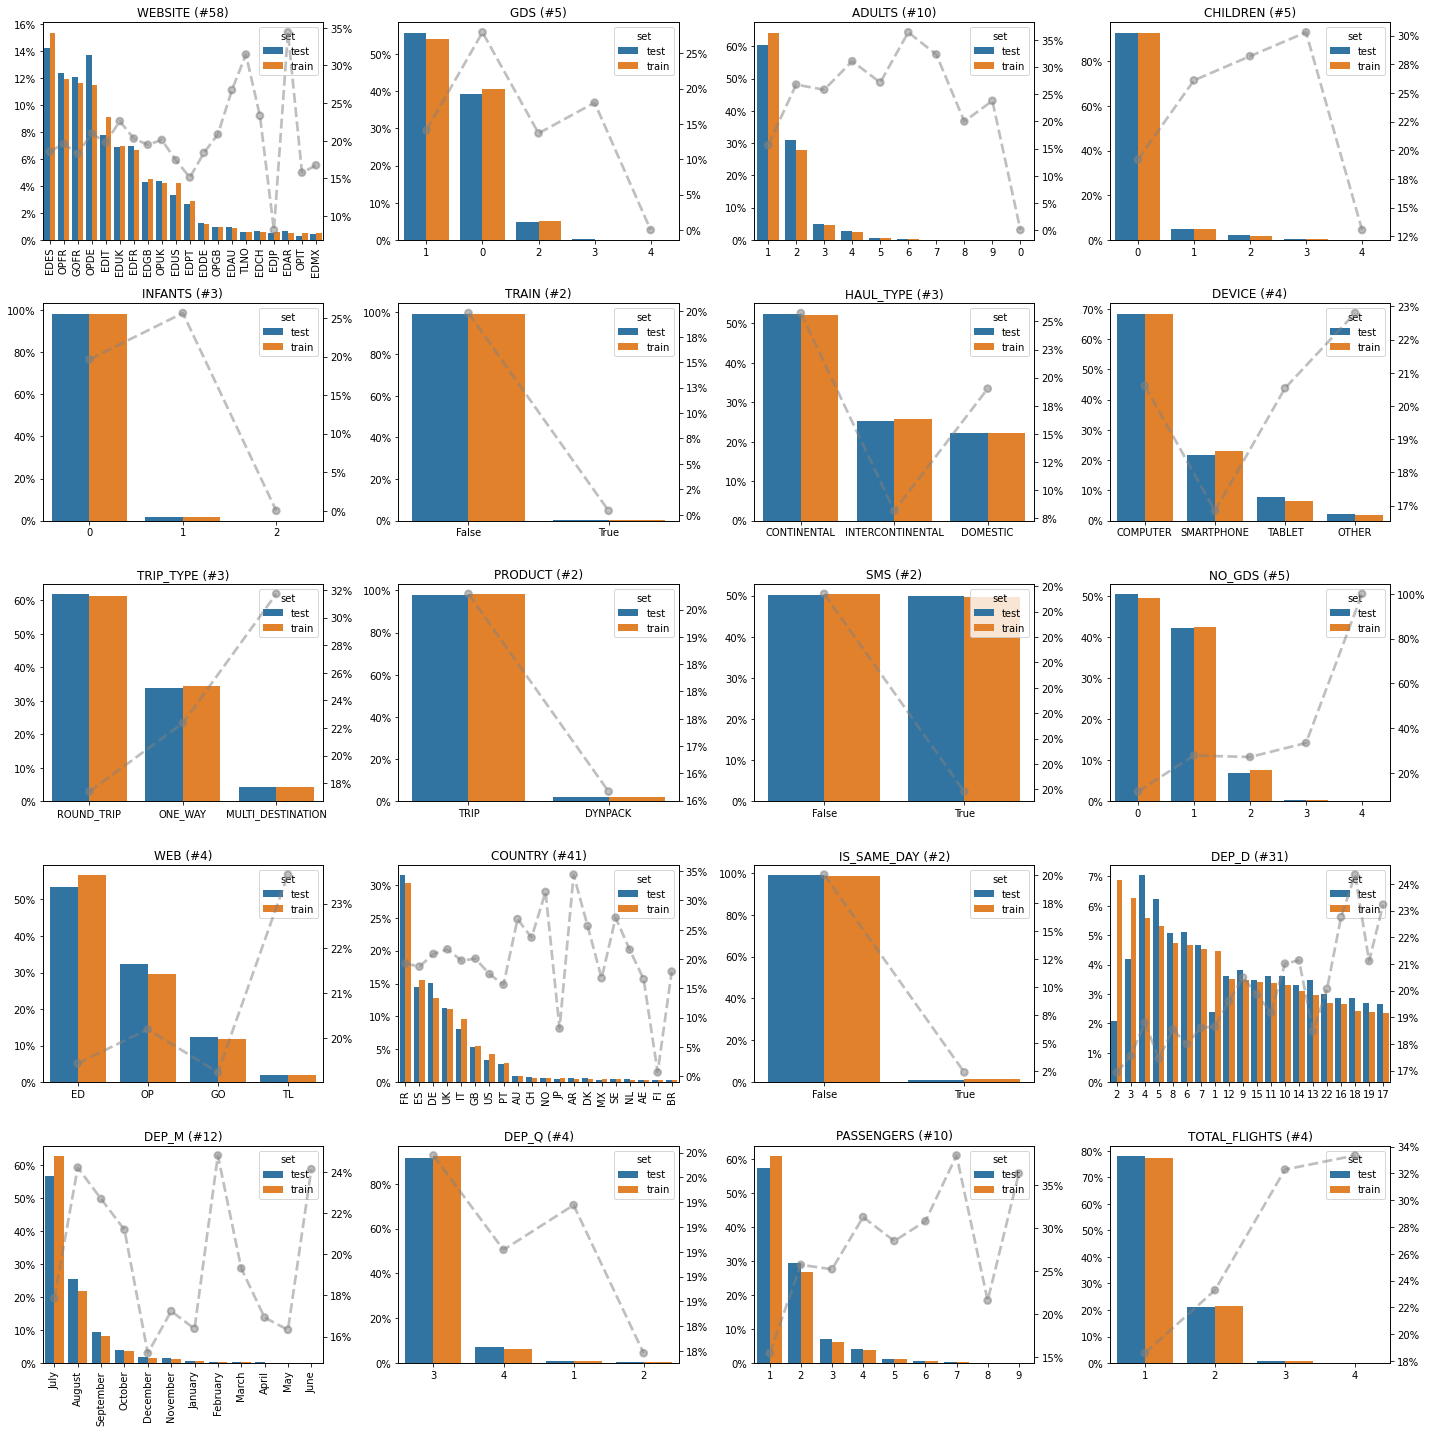

In [27]:
def plot_train_vs_test(train, test, cat_cols, nc=3, show_max=25):
    nr = (len(cat_cols) // nc) #+ 1
    f, axs = plt.subplots(nr, nc, figsize=(nc*5, 4*nr))
    axs = axs.flatten()
    
    for i, col in enumerate(cat_cols):
        order = train[col].value_counts().index[:show_max]
        
        # Combine train and test
        x = pd.concat([
            train[[col]].assign(set='train'), 
            test[[col]].assign(set='test')
        ], axis=0 )
        
        # Plot
        counts = x.groupby(['set'])[col].value_counts(normalize=True).rename('counts').reset_index().fillna(0)
        p_1 = sns.barplot(x=col, y="counts", hue="set", data=counts, order=order, ax=axs[i])
        p_1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        # p_1 = sns.countplot(x=col, hue='set', order=order, data=x, ax=axs[i])        
        axs[i].set_title(f'{col} (#{x[col].nunique()})')
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        if col in ['WEBSITE', 'COUNTRY', 'DEP_W', 'DEP_M']:
            plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)
            
        # Append TARGET mean by category
        tmp = pd.crosstab(train[col], train[TARGET], normalize='index').reset_index()
        tmp.rename(columns={0: 'target_0', 1: 'target_1'}, inplace=True)

        p_2 = p_1.twinx()
        p_2 = sns.pointplot(x=col, y='target_1', data=tmp, color='grey', 
                            order=order, legend=False, linestyles='--')
        plt.setp(p_2.collections, alpha=.5) # for the markers
        plt.setp(p_2.lines, alpha=.5)       # for the lines
        p_2.set_ylabel('')
        p_2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
        
    plt.tight_layout()
    
# Display plots
plot_train_vs_test(train, test, cat_cols, nc=4, show_max=20)

Low frequency countries

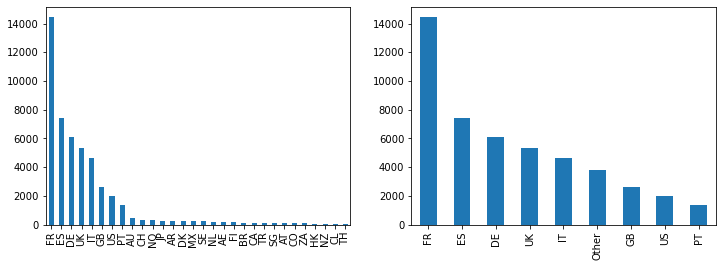

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
order = train['COUNTRY'].value_counts().index
train['COUNTRY'].value_counts()[:30].plot(kind='bar', ax=axs[0])

# https://stackoverflow.com/questions/47418299/python-combining-low-frequency-factors-category-counts
series = pd.value_counts(train['COUNTRY'])
mask = (series/series.sum() * 100).lt(1)
new_country = np.where(train['COUNTRY'].isin(series[mask].index),'Other', train['COUNTRY'])
pd.value_counts(new_country).plot(kind='bar', ax=axs[1])
plt.show()

## Numeric columns

Similar to our previous analysis, we will inspect the density distributions of the numeric features. In blue we see the distribution when the `EXTRA_BAGGAGE` = False and in orange when is True.

* Despite the distribution of the **DISTANCE** is not so different I think that the algorithm would be able to use this feature to enhance out predictions.
* **DAYS_TO_FLIGHT**: People tend to book their flights between 0 and 60 days in advance
* **TRIP_DAYS**: There is no difference in the distributions.
* **ADULTS_RATIO**: Seems a very important feature because we see that some areas of the distributions doesn't overlap.

Most of the distributions are right skewed and some kind of transformation will be needed.

In [29]:
exclude = ['GDS', 'NO_GDS', 'PASSENGERS', 'ADULTS', 'CHILDREN', 'INFANTS']
num_cols = train.select_dtypes('number').columns.drop(exclude)
num_cols

Index(['DISTANCE', 'DAYS_TO_FLIGHT', 'TRIP_DAYS', 'DEP_D', 'ADULTS_RATIO',
       'CHILDREN_RATIO', 'INFANTS_RATIO', 'TOTAL_FLIGHTS'],
      dtype='object')

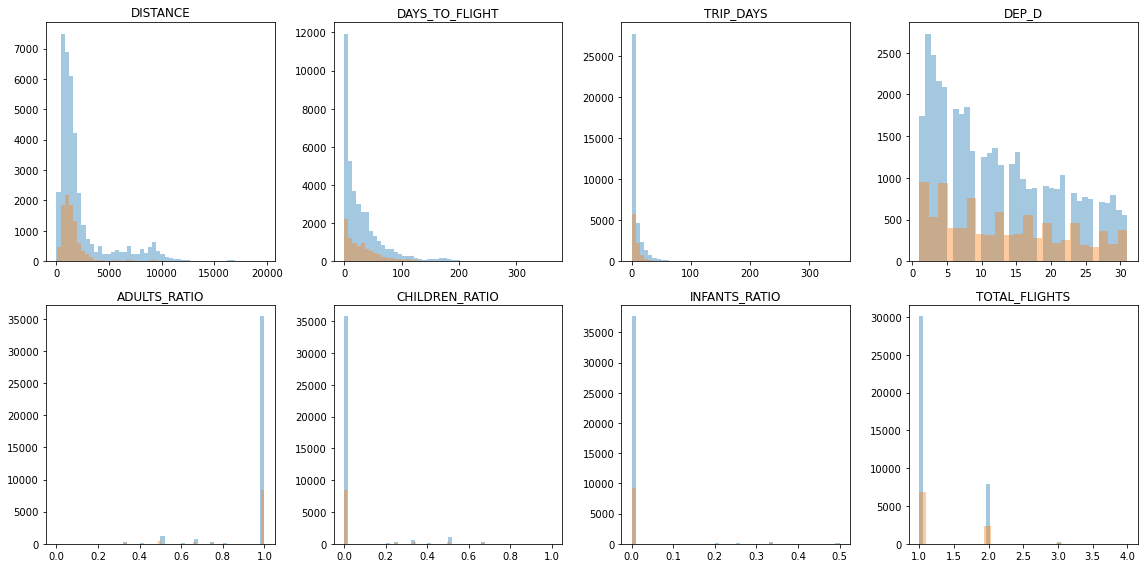

In [30]:
def plot_numeric(train, num_cols, nc=3):
    nr = (len(num_cols) // nc) #+ 1
    f, axs = plt.subplots(nr, nc, figsize=(min(nc*5, 16), 4*nr))
    axs = axs.flatten()
    
    train_0 = train[ train[TARGET]==False ].copy()
    train_1 = train[ train[TARGET]==True ].copy()
    
    for i, col in enumerate(num_cols):
        sns.distplot(train_0[col], kde_kws={"label": f'{TARGET}=0', 'bw': 1}, hist=True, kde=False, ax=axs[i])
        sns.distplot(train_1[col], kde_kws={"label": f'{TARGET}=1', 'bw': 1}, hist=True, kde=False, ax=axs[i])
        axs[i].set_title(col)
        axs[i].set_xlabel('')
    plt.tight_layout()
    
# Display plots
plot_numeric(train, num_cols, nc=4)

After seeing that `DISTANCE` seems to be formed by multiple distributions let's investigate if there is any categorical variable that interacts with it. For example, distance of the intercontinental flights must be longer than domestic flights. Are intercontinental trips longer than domestic ones?

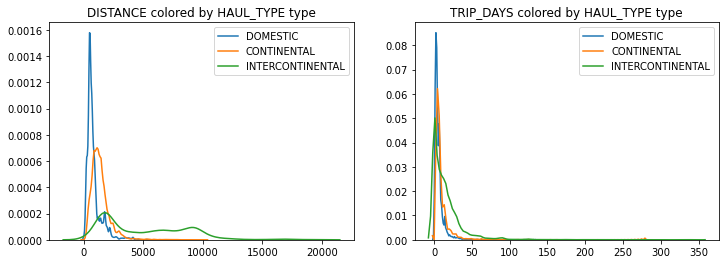

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
cat_col = 'HAUL_TYPE'
num_col = 'DISTANCE'
for c in train[cat_col].unique():
    mask = train[cat_col] == c
    p = sns.kdeplot(train.loc[mask, num_col], label=f'{c}', ax=axs[0])
p.set_title(f'{num_col} colored by {cat_col} type')

cat_col = 'HAUL_TYPE'
num_col = 'TRIP_DAYS'
for c in train[cat_col].unique():
    mask = train[cat_col] == c
    p = sns.kdeplot(train.loc[mask, num_col], label=f'{c}')
p.set_title(f'{num_col} colored by {cat_col} type')
plt.show()

In [32]:
# Existen viajes con distancia 0. y todos ellos son EXTRA_BAGGAGE = 0. Es porque viajan en tren?
# train.query('TRAIN == True').mean()
# train.query('DISTANCE == 0').groupby([TARGET])[TARGET].mean()
# train.query('DISTANCE == 0').mean()
# # Create new feature
# train['DISTANCE_0'] = train['DISTANCE'] == 0
# test['DISTANCE_0'] = test['DISTANCE'] == 0

In [33]:
# # train['DISTANCE'].min()
# c = 'DISTANCE'
# a = train[[TARGET, c]].copy()
# a['CUT'] = pd.cut(a[c], bins=5)
# a.head()
# a.groupby(['CUT'])[TARGET].mean().plot(kind='bar');

`ONE_WAY` flights have `TRIP_DURATION` = 0 because they just have bought 1 ticket. Let's filter out the data and apply a `log`/`Yeo-Johnson` transformation to see how the distribution looks like. The `Yeo-Johnson` transformations is applied to make data more Gaussian-like.

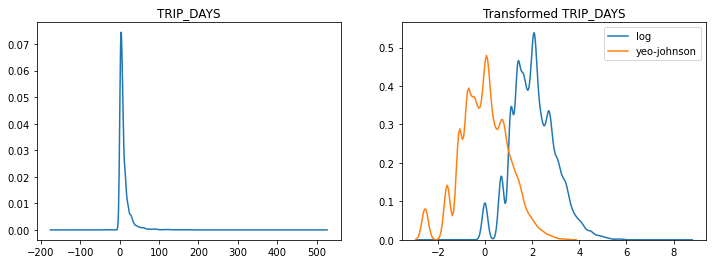

In [34]:
col = 'TRIP_DAYS'
tmp = train.query('TRIP_TYPE != "ONE_WAY"')[[col]]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
p_1 = tmp[col].plot(kind='kde', ax=axs[0])
p_1.set_title(col)
p_1.set_ylabel('')

transformer = PowerTransformer(method='yeo-johnson')
p_2 = np.log1p(tmp[col]).plot(kind='kde', ax=axs[1], label='log')
x = transformer.fit_transform(tmp[col].values.reshape(-1, 1))
sns.distplot(x, hist=False, ax=axs[1], label='yeo-johnson')
p_2.set_title(f'Transformed {col}')
p_2.set_ylabel('')
plt.show()

In [35]:
a = train[['TRIP_DAYS', 'TRIP_TYPE']]
a.groupby(['TRIP_TYPE']).agg(max)
q = a['TRIP_DAYS'].quantile(q=0.99)
n = a.query('TRIP_DAYS>69').shape[0]
n_2 = a.query('TRIP_DAYS>69')['TRIP_TYPE'].astype(str).unique()
print(f'Quantile 99 of TRIP_DAYS: {q}\n'
      f'There are {n} booked trips with more than {q} TRIP_DAYS\n'
      f'Corresponding TRIP_TYPE: {n_2}')
# Show distriution without outliers
#np.log1p(a.query('TRIP_DAYS<69')['TRIP_DAYS']).hist()
#a.query('TRIP_DAYS>294')[base_features]

Quantile 99 of TRIP_DAYS: 69.0
There are 473 booked trips with more than 69.0 TRIP_DAYS
Corresponding TRIP_TYPE: ['ROUND_TRIP' 'MULTI_DESTINATION']


In [36]:
# v = ['ADULTS', 'CHILDREN', 'INFANTS', 'NO_GDS', 'GDS', 'TOTAL_FLIGHTS']
# df_subset = train.sample(10000).copy()
# sns.pairplot(df_subset, hue=TARGET, vars=v, diag_kind="kde");

In [37]:
# df_subset = pd.concat([train.sample(10000).assign(set='Train'), 
#                        test.sample(10000).assign(set='Test')
#                       ], sort=False, axis=0)
# sns.pairplot(df_subset.sample(1000), hue='set', vars=num_cols, diag_kind="kde");

## Missing values

As seen before, all the missing values of this dataset are concentrated in the `DEVICE` feature. But how are they distributed? All of them belong to the same web or country?

* Over 79% of the missign values belong to eDreams website, 18% to Opodo and 3% to Go Voyage.
* The countries with the higher percentage of missing values are Spain and UK with 60% and 20% respectively.

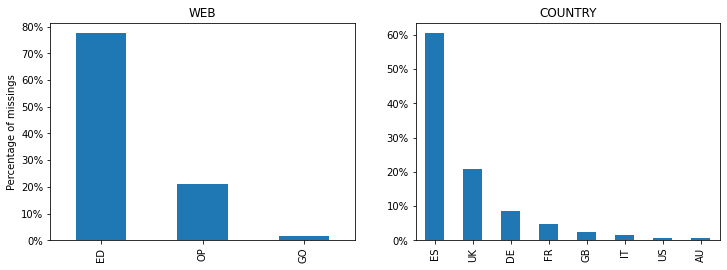

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
total_na = train['DEVICE'].isnull().sum()
col = 'WEB'
x = train[['DEVICE', col]].copy()
x['DEVICE'] = train['DEVICE'].cat.add_categories('Missing')
x['DEVICE'].fillna('Missing', inplace =True)
counts = x.query('DEVICE == "Missing"').groupby(col)['DEVICE'].count() / total_na
p = counts[counts > 0].sort_values(ascending=False).plot(kind='bar', ax=axs[0])
p.set_xlabel('')
p.set_ylabel('Percentage of missings')
p.set_title(col)
p = p.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

col = 'COUNTRY'
x = train[['DEVICE', col]].copy()
x['DEVICE'] = train['DEVICE'].cat.add_categories('Missing')
x['DEVICE'].fillna('Missing', inplace =True)
counts = x.query('DEVICE == "Missing"').groupby(col)['DEVICE'].count() / total_na
p = counts[counts > 0].sort_values(ascending=False).plot(kind='bar', ax=axs[1])
p.set_xlabel('')
p.set_title(col)
p.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

In [39]:
# Impute values
col = 'DEVICE'
mask = train[col].isna()
most_frequent = train[col].value_counts().index[0]
train.loc[mask, col] = most_frequent
train['DEVICE_NA'] = mask
mask = test[col].isna()
test.loc[mask, col] = most_frequent
test['DEVICE_NA'] = mask

# Adversarial validation

The basic idea is to identify shift between train and test sets (it is also called Covariate Shift).

If there exists a shift in the dataset, then on mixing the train and test file, our model should still be able to classify an instance of the mixed dataset as train or test with reasonable accuracy. Why? Because, if the features in both the dataset belong to different distributions then, they should be able to separate the dataset into train and test file significantly.

Lets check a covariate shift of each feature in the data set. This means that we will try to distinguish whether a values correspond to a training set or to a testing set.

In [40]:
def adversarial_validation(train, test, features=None, verbose=False):
    features = test.columns if features is None else features
    if ~isinstance(features, list):
        features = list(features)

    # Concatenate data in one DataFrame and subset features
    train_test = pd.concat(
        [
            train[features].assign(target = 0), 
            test[features].assign(target = 1) 
        ], 
        axis=0, sort=False
    )
    y = train_test['target'].values
    
    # Label Encoding
    cat_cols = train_test.select_dtypes(exclude=['number', 'bool']).columns.to_list()
    encoder = ce.OrdinalEncoder(cols=cat_cols, return_df=True)
    train_test = encoder.fit_transform(train_test)

    # Split data for modeling
    X_train, X_test, y_train, y_test = train_test_split(
        train_test, y, test_size=0.4, random_state=42, shuffle=True)

    rocs = {}
    for col in features:
        dtrain = lgb.Dataset(X_train[[col]], label=y_train)
        dtest = lgb.Dataset(X_test[[col]], label=y_test)

        param = {
            'num_leaves': 50,
            'min_data_in_leaf': 30,
            'objective': 'binary',
            'max_depth': 5,
            'learning_rate': 0.2,
            "min_child_samples": 20,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "bagging_freq": 1,
            "bagging_fraction": 0.9,
            "bagging_seed": 44,
            "metric": 'auc',
            "verbosity": 1
        }

        # Train the model
        num_round = 50
        clf = lgb.train(
            param,
            dtrain,
            num_round,
            valid_sets=[dtrain, dtest],
            verbose_eval=0,
            early_stopping_rounds=50)

        rocs[col] = roc_auc_score(y_test, clf.predict(X_test[[col]]))
        if verbose:
            print(f'ROC AUC score: {round(rocs[col], 3)} \t{col}')

    return pd.DataFrame.from_dict(
        rocs, orient='index', columns=['ROC']).sort_values(
        by='ROC', ascending=False).head(10)

Cool! All features provide a ROC AUC of roughly 0.5 which means that the model is not able to distinguish if the feature belong to training set or testing set.

In [41]:
features = base_features #test.columns
adversarial = adversarial_validation(train, test, features, verbose=True)

ROC AUC score: 0.526 	WEBSITE
ROC AUC score: 0.512 	GDS
ROC AUC score: 0.5 	DEPARTURE
ROC AUC score: 0.5 	ARRIVAL
ROC AUC score: 0.518 	ADULTS
ROC AUC score: 0.503 	CHILDREN
ROC AUC score: 0.501 	INFANTS
ROC AUC score: 0.5 	TRAIN
ROC AUC score: 0.5 	HAUL_TYPE
ROC AUC score: 0.512 	DISTANCE
ROC AUC score: 0.513 	DEVICE
ROC AUC score: 0.491 	TRIP_TYPE
ROC AUC score: 0.501 	PRODUCT
ROC AUC score: 0.501 	SMS
ROC AUC score: 0.511 	NO_GDS


# One predictor
In this section we will analyze the predictive power of each predictor independently. To do this, two models will be created, a first model ($M_1$) with the predictor to be analyzed and a second model ($M_2$), a dummy model. Next, the `roc_auc` of both models will be analyzed and a one sided `t-test` will be applied to determine if the $M_1$ model is statistically better than the $M_2$ model. In order to obtain a reliable measure *RepeatedStratifiedKFold* with 3 splits and 10 repeats will be used.

A one-sided t-test is used to compare the mean of one sample to a known standard mean, that is, in this case we will test wheter the difference of roc_auc ($M_1$-$M_2$) is greater than zero.

The null hypotesis ($H_0$) of the t-test is that both models are equals while the alternative ($H_1$) is that $M_1$>$M_2$.

$H_0: m = \mu \\
H_1: m > \mu$

The t-statistic can be calculated as follow:
$$t = \frac{m - \mu}{ \dfrac{s}{\sqrt{n}} }$$

$where$, <br>
$m$ is the sample mean<br>
$n$ is the sample size<br>
$s$ is the sample standard deviation with $n−1$ degrees of freedom <br>
$\mu$ is the theoretical value

In [42]:
train_encoded = train.copy()
to_encode = train_encoded.select_dtypes(include=['category']).columns.to_list()
encoder = ce.OrdinalEncoder(cols=to_encode, return_df=True)
train_encoded = encoder.fit_transform(train_encoded)

In [43]:
def compare_models_1way(s_1, s_2):
    improvement = s_2.mean() - s_1.mean()
    stat, p = stats.ttest_1samp(s_2 - s_1, 0)
    return stat, p, improvement

# Train one predictor at time
def train_one_pred(pipe, train, features, verbose=False):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)
    y = train[TARGET].values
    X = train[features].copy()
    null_model = DummyClassifier(strategy='most_frequent', random_state=42)
    res = {}
    for f in tqdm(features):
    #for f in features:
        scores_1 = cross_val_score(null_model, X[[f]], y, scoring='roc_auc', cv=cv)
        scores_2 = cross_val_score(pipe, X[[f]], y, scoring='roc_auc', cv=cv, n_jobs=1)
        _, p, imp = compare_models_1way(scores_1, scores_2)
        res[f] = imp, p, scores_2.mean()
        if verbose:
            print(f'{f:31} Improvement: {imp:.4f}\tPvalue: {p:.4f}\t ROC: {scores_2.mean():.4f}')
    return pd.DataFrame.from_dict(
        res, orient='index', columns=['Improvement', 'Pvalue', 'ROC']).sort_values(
        by='Improvement', ascending=False)

# Create pipeline to use
clf = RandomForestClassifier(n_estimators=10, random_state=42,
                             max_features='auto', min_samples_leaf=7,
                             criterion='entropy', n_jobs=-1)
# Evaluate predictors
features = train.columns.drop(TARGET)
one_pred = train_one_pred(clf, train_encoded, features, verbose=False)
one_pred.head(12)

,Improvement,Pvalue,ROC
DISTANCE,0.149242,6.319796e-47,0.649242
NO_GDS,0.127252,9.693327e-43,0.627252
HAUL_TYPE,0.118435,6.928071e-47,0.618435
GDS,0.105155,5.772198e-42,0.605155
TRIP_DAYS,0.090930,2.542462e-36,0.590930
PASSENGERS,0.084999,2.524372e-38,0.584999
ADULTS,0.084003,3.706160e-38,0.584003
DAYS_TO_FLIGHT,0.057534,8.794125e-35,0.557534
DEPARTURE,0.056041,7.416669e-35,0.556041
ARRIVAL,0.053549,3.156304e-34,0.553549


Most of the predictors are statistically significant which means that they provide some kind of information. However, there are a couple of them that does not help the model to predict the outcome. 

In [44]:
one_pred.query('Pvalue >= 0.05 | Improvement < 0')

,Improvement,Pvalue,ROC
DEP_Q,0.000556,0.197737,0.500556
SMS,-0.000849,0.232212,0.499151


# Random Forest
The baseline model use the features that comes into the original data set, without any additional pre-process nor added ones. Once we have this model, we will be able to measure the impact of the new features generated. Finally we will tune the hyper parameters of the model to see how much (if possible) we can improve the model. 

*Note: the only preproces done is encode categorical features*

In [45]:
def split_data(X, y, train_index, valid_index):
    X_train, y_train = X[train_index].copy(), y[train_index].copy()
    X_valid, y_valid = X[valid_index].copy(), y[valid_index].copy()
    return X_train, y_train, X_valid, y_valid

def show_results(cv_results):
    scores_1 = cv_results['train_score']
    scores_2 = cv_results['test_score']
    print("ROC AUC: %0.4f || %0.4f (+/- %0.2f)" % 
      (scores_1.mean(), scores_2.mean(), scores_2.std() * 2))

train_index = timestamp.astype(str) == '2017-07-01T00:00:00.000000000'
valid_index = timestamp.astype(str) == '2017-07-02T00:00:00.000000000'
print(f'Train samples: {train_index.sum()}\nValid samples: {valid_index.sum()}')
y_preds = {}
scores = {}

Train samples: 35784
Valid samples: 11912


In [46]:
f = base_features.drop(['DEPARTURE', 'ARRIVAL']).to_list()
y = train_encoded[TARGET]
X = train_encoded[f]

# Split features
X_train, y_train, X_valid, y_valid = split_data(
    X, y, train_index, valid_index)

# Create folds
cv_groups = X_train['DISTANCE'].values
cv = StratifiedKFold(n_splits=5, random_state=42)
cvg = list(GroupKFold(n_splits=5).split(X_train, y_train, cv_groups))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [47]:
clf = RandomForestClassifier(n_estimators=10, random_state=42,
                             max_features='auto', min_samples_leaf=7,
                             criterion='entropy', n_jobs=-1)

# Evaluate results
cv_results = cross_validate(
    clf, X_train, y_train, scoring='roc_auc', cv=cv,
    return_train_score=True, return_estimator=True)
show_results(cv_results)

# Make predictions using each estimator
y_oof = [estimator.predict_proba(X_valid)[:, 1] for estimator in cv_results['estimator']]
y_preds['Baseline'] = np.mean(y_oof, axis=0)
scores['Baseline'] = (cv_results['train_score'], cv_results['test_score'])

ROC AUC: 0.8326 || 0.7217 (+/- 0.02)


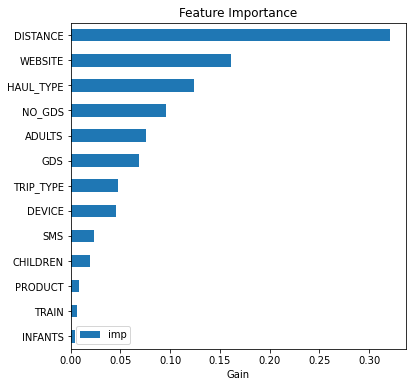

In [48]:
# Feature importance
importance = pd.DataFrame(index=X_train.columns.to_list())
importance['imp'] = np.mean([e.feature_importances_ for e in cv_results['estimator']], axis=0)
importance = importance.sort_values(by='imp', ascending=True)
importance.tail(25).plot(kind='barh', figsize=(6, 6))
plt.title('Feature Importance')
plt.xlabel('Gain')
plt.show()

## Distance in depth
The most important variable of the previous Random Forest is the **DISTANCE** so it is worth analyzing it with a little more detail. If we think of a typical flight, for example BCN-MAD always has the same distance, so it would make sense that if we filter by a specific distance we were always referring to the same flight. 

In [49]:
mask = train['DISTANCE'] == 19766.1
train.loc[mask, base_features.to_list() + [TARGET, 'TRIP_DAYS']]

,WEBSITE,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,NO_GDS,EXTRA_BAGGAGE,TRIP_DAYS
ID,,,,,,,,,,,,,,,,,
2726,EDCO,1,2017-07-01,2017-07-18,1,0,0,False,INTERCONTINENTAL,19766.1,COMPUTER,ROUND_TRIP,TRIP,True,0,False,17
16237,EDCO,1,2017-07-01,2017-07-18,1,0,0,False,INTERCONTINENTAL,19766.1,COMPUTER,ROUND_TRIP,TRIP,False,0,False,17
23450,EDUS,1,2017-07-01,2017-07-16,1,0,0,False,INTERCONTINENTAL,19766.1,COMPUTER,ROUND_TRIP,TRIP,True,0,False,15
30267,EDUS,1,2017-07-01,2017-07-16,1,0,0,False,INTERCONTINENTAL,19766.1,COMPUTER,ROUND_TRIP,TRIP,False,0,False,15


Let's see another example

In [50]:
mask = train['DISTANCE'] == 809.174
train.loc[mask, base_features.to_list() + [TARGET, 'TRIP_DAYS']].head(4)

,WEBSITE,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,NO_GDS,EXTRA_BAGGAGE,TRIP_DAYS
ID,,,,,,,,,,,,,,,,,
1397,EDFR,0,2017-07-15,2017-07-15,1,0,0,False,DOMESTIC,809.174,SMARTPHONE,ONE_WAY,TRIP,False,1,False,0
2190,OPFR,1,2017-08-20,2017-08-21,1,0,0,False,DOMESTIC,809.174,COMPUTER,ROUND_TRIP,TRIP,False,1,False,1
6933,OPFR,0,2017-08-03,2017-08-09,1,0,0,False,DOMESTIC,809.174,COMPUTER,ROUND_TRIP,TRIP,False,1,False,6
7653,OPFR,0,2017-07-04,2017-07-06,2,0,0,False,DOMESTIC,809.174,COMPUTER,ROUND_TRIP,DYNPACK,True,1,True,2


Cool! Everything seems to fit together. According to this reasoning, for a single flight all **HAUL_TYPE** should be the same because the BCN-MAD flight will always be a domestic flight. Let's check it out.

In [51]:
tmp = train.groupby(['DISTANCE'])['HAUL_TYPE'].nunique().sort_values(ascending=False)
tmp_n = tmp[tmp > 1].sum()
print(f'There are {tmp_n} ({100*tmp_n/tmp.shape[0]:.2f}%) DISTANCES with more than one HAUL_TYPE')

There are 191 (1.79%) DISTANCES with more than one HAUL_TYPE


It seems to be met in most cases, however, we see that in a few cases we have different types of flights for the same **DISTANCE**. Finally, let's assume that each DISTANCE - HAUL_TYPE identifies a different flight and could be considered the segment **ID**.

In [52]:
mask = train['DISTANCE'] == 0.0
train.loc[mask, base_features.to_list() + [TARGET, 'TRIP_DAYS']].head()

,WEBSITE,GDS,DEPARTURE,ARRIVAL,ADULTS,CHILDREN,INFANTS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,NO_GDS,EXTRA_BAGGAGE,TRIP_DAYS
ID,,,,,,,,,,,,,,,,,
166,EDES,0,2017-07-02,2017-07-02,1,0,0,True,INTERCONTINENTAL,0.0,SMARTPHONE,ONE_WAY,TRIP,False,1,False,0
179,EDAU,1,2017-07-14,2017-07-14,1,0,0,False,DOMESTIC,0.0,COMPUTER,ONE_WAY,TRIP,False,0,False,0
255,EDES,0,2017-07-03,2017-07-03,2,0,0,True,INTERCONTINENTAL,0.0,TABLET,ONE_WAY,TRIP,True,1,False,0
271,EDES,0,2017-07-03,2017-07-03,1,0,0,True,INTERCONTINENTAL,0.0,COMPUTER,ONE_WAY,TRIP,True,1,False,0
445,EDES,0,2017-07-06,2017-07-18,1,0,0,True,INTERCONTINENTAL,0.0,COMPUTER,ROUND_TRIP,TRIP,False,1,False,12


Next, it is shown for each DISTANCE if it exists in a certain date. Samples in yellow indicate that a DISTANCE exists while blue indicates that it does not. For example, the distance 1837.06 exists on July 01 but does not exist on any other date.

It should be remembered that the first two dates, July 01 and 02, belongs to the TRAIN file and the rest, July 03 and 04 to the TEST period.

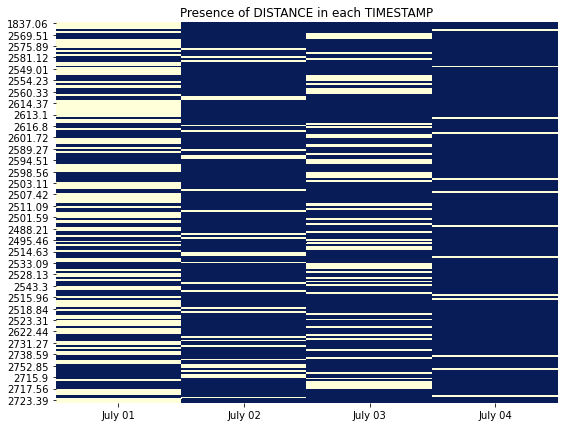

In [53]:
tmp_1 = train[['DISTANCE']].assign(TIMESTAMP=timestamp)
tmp_2 = test[['DISTANCE']].assign(TIMESTAMP=timestamp_test)
tmp = pd.concat([tmp_1, tmp_2], axis=0).assign(DAY=1)
tmp = tmp.drop_duplicates(keep='first')
tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP'].values).strftime('%B %d')
tmp = tmp.pivot('DISTANCE', 'TIMESTAMP', 'DAY').fillna(2)
tmp['order'] = tmp.sum(axis=1)
tmp = tmp.sort_values(by='order', ascending=False).drop('order', axis=1).head(200)
tmp.head()

# Show plot
fig, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(tmp, cmap="YlGnBu", cbar=False, ax=ax)
ax.set_title('Presence of DISTANCE in each TIMESTAMP')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [54]:
# col = 'DISTANCE'
# train_counts = train[col].value_counts(sort=False)
# test_counts = test[col].value_counts(sort=False)
# all_counts = pd.concat([train[col], test[col]]).value_counts(sort=False)
# a = pd.concat([train_counts, test_counts, all_counts], axis=1, sort=False)#.fillna(0)
# a.columns = ['train', 'test', 'counts']
# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].scatter(a.index, np.log1p(a.train), alpha=0.1, marker='+', c='r')
# axs[0].scatter(a.index, np.log1p(a.test), alpha=0.1, marker='+', c='b')
# axs[0].legend()
# axs[1].scatter(np.log1p(a.counts), np.log1p(a.train), alpha=0.1, marker='+', c='r')
# axs[1].scatter(np.log1p(a.counts), np.log1p(a.test), alpha=0.1, marker='+', c='b')
# axs[1].legend()
# plt.show()

# Feature Engineering

## Aggregations

At the beginning of the notebook we saw that not all the distances available in the TRAIN exist in the TEST and vice versa, in fact a %% of the distances in the TEST do not exist in the TRAIN. Furthermore, during the DISTANCE analysis we have concluded that we can use the DISTANCE-HAUL_TYPE as a flight identifier. 

This means that our model has to be able to predict unseen distances (segments). To do this we will create new features, most aggregations and counts so that without using the segment (DISTANCE-HAUL_TYPE) the algorithm must be able to identify it.

Additionaly to this aggregates, some target encoding features will be added to the data frame. Target encoding is the process of replacing a categorical value with the mean of the target variable.

For example, target encoding for `HAUL_TYPE` could be:

| HAUL_TYPE 	   | HAUL_TYPE_TE   |
|:--------------   |:-------------- |
| DOMESTIC         | 0.18          	|
| CONTINENTAL      | 0.26          	|
| INTERCONTINENTAL | 0.08          	|

In [55]:
def TargetEncoder(train_test, groups, targets, agg_funs, fill_na=True, verbose=True):
    init_cols = train_test.columns.to_list()
    for group in groups:
        df_group = train_test.groupby(group)
        for target in targets:
            if verbose: print(f'Grouping by {group} - Encoding: {target}')
            prefix = ['_'.join(group)] if isinstance(group, list) else [group]
            prefix = '_'.join(prefix + [target])
            #print(prefix)
            new_features = df_group[target].agg(agg_funs).add_prefix(f'{prefix}_').reset_index()
            new_columns = new_features.drop(group, axis=1).columns.to_list()
            train_test = train_test.merge(new_features, how='left', on=group)
            #train_test.drop(target, axis=1, inplace=True)
            if fill_na:
                train_test[new_columns] = train_test[new_columns].fillna(-1)
    end_cols = train_test.columns.to_list()
    new_columns = list(set(init_cols) - set(end_cols))
    return train_test, new_columns

def FrequencyEncoder(train_test, cols, verbose=True):
    for col in cols:
        vc = train_test[col].value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        train_test[col + '_FE'] = train_test[col].map(vc).astype('float32')
        if verbose: print(col + '_FE',', ',end='')
    return train_test

def CreateAggregations(df):
    # Copy the original DataFrame
    df = df.copy()
    
    # Create aggregations
    for f in ['DEVICE', 'TRIP_TYPE', 'PRODUCT', 'COUNTRY', 'WEB']:
        df, _ = TargetEncoder(df, [
            ['WEBSITE'],
            ['HAUL_TYPE'],
            ['DISTANCE'],
            ['DISTANCE', 'HAUL_TYPE'],
            ['DISTANCE', 'HAUL_TYPE', 'WEBSITE']
          ], [f], ['nunique'], verbose = False)

    # Frequency encoder
    df = FrequencyEncoder(df,
        ['DISTANCE', 'HAUL_TYPE', 'WEBSITE', 'DEVICE', 'TRIP_TYPE', 
         'PRODUCT', 'COUNTRY', 'WEB', 
        # New
        #'DEPARTURE', 'ARRIVAL'
        ], verbose = False)

    # Target Encoder by month ?
    df, _ = TargetEncoder(df,
        ['DEP_M', 'HAUL_TYPE', 'WEBSITE'], [TARGET], ['mean', 'std'],
        verbose = False)

    df, _ = TargetEncoder(df,
        [
            ['DISTANCE', 'HAUL_TYPE']
        ],
        ['ADULTS', 'CHILDREN', 'GDS', 'NO_GDS', 'SMS', 'ADULTS_RATIO', 'TRIP_DAYS',
         'PASSENGERS', 'TOTAL_FLIGHTS', 'IS_SAME_DAY'],
        ['mean', 'std'], 
        verbose = False)
    return df

In [56]:
# New training set with aggregated features
train_new = CreateAggregations(train)

In [57]:
to_drop = [TARGET, 'DEPARTURE', 'ARRIVAL', 'DISTANCE', 'HAUL_TYPE', 'WEBSITE']
f = train_new.columns.drop(to_drop).to_list()
y = train_new[TARGET]
X = train_new[f]

# Split data into train & validation
X_train, y_train, X_valid, y_valid = split_data(
    X, y, train_index, valid_index)

# Encode categorical variables
to_encode = X_train.select_dtypes(exclude=['number', 'bool']).columns.to_list()
encoder = ce.OrdinalEncoder(cols=to_encode, return_df=True)
X_train = encoder.fit_transform(X_train)
X_valid = encoder.fit_transform(X_valid)
X_train.head()

,GDS,ADULTS,CHILDREN,INFANTS,TRAIN,DEVICE,TRIP_TYPE,PRODUCT,SMS,NO_GDS,...,DISTANCE_HAUL_TYPE_ADULTS_RATIO_mean,DISTANCE_HAUL_TYPE_ADULTS_RATIO_std,DISTANCE_HAUL_TYPE_TRIP_DAYS_mean,DISTANCE_HAUL_TYPE_TRIP_DAYS_std,DISTANCE_HAUL_TYPE_PASSENGERS_mean,DISTANCE_HAUL_TYPE_PASSENGERS_std,DISTANCE_HAUL_TYPE_TOTAL_FLIGHTS_mean,DISTANCE_HAUL_TYPE_TOTAL_FLIGHTS_std,DISTANCE_HAUL_TYPE_IS_SAME_DAY_mean,DISTANCE_HAUL_TYPE_IS_SAME_DAY_std
0,1,1,0,0,False,1,2,1,True,0,...,0.943333,0.167912,4.400000,4.949747,1.760000,1.051982,1.360000,0.489898,0.0,0.0
1,0,1,0,0,False,2,1,1,False,1,...,0.956522,0.144052,6.956522,10.472814,1.260870,0.688700,1.000000,0.000000,0.0,0.0
2,2,1,0,0,False,1,2,1,True,0,...,1.000000,0.000000,8.666667,6.623192,1.166667,0.408248,1.666667,0.516398,0.0,0.0
3,0,1,0,0,False,2,3,1,False,2,...,0.951111,0.129631,2.866667,3.583029,1.666667,1.112697,1.066667,0.258199,0.0,0.0
4,0,1,0,0,False,3,1,1,False,1,...,1.000000,0.000000,0.000000,0.000000,1.333333,0.577350,1.000000,0.000000,0.0,0.0


In [58]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=9,
                             max_features='auto', criterion='entropy', n_jobs=-1) 
# class_weight='balanced'

# Evaluate results
cv_results = cross_validate(
    clf, X_train, y_train, scoring='roc_auc', cv=cv,
    return_train_score=True, return_estimator=True)
show_results(cv_results)
scores['RF'] = (cv_results['train_score'], cv_results['test_score'])

# Make predictions using each estimator
y_oof = [estimator.predict_proba(X_valid)[:, 1] for estimator in cv_results['estimator']]
y_preds['RF'] = np.mean(y_oof, axis=0)
# print(roc_auc_score(y_valid, y_preds['RF']))

ROC AUC: 0.8434 || 0.7681 (+/- 0.01)


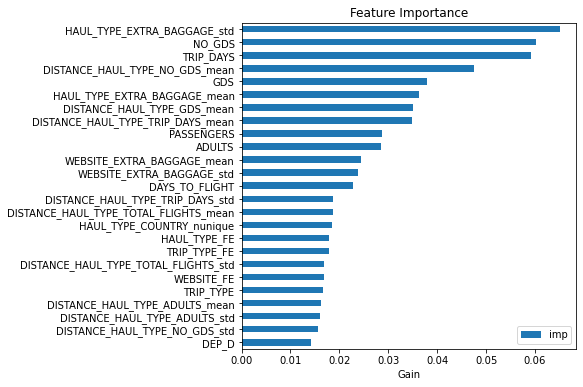

In [59]:
# Feature importance
importance = pd.DataFrame(index=X_train.columns.to_list())
importance['imp'] = np.mean([e.feature_importances_ for e in cv_results['estimator']], axis=0)
importance = importance.sort_values(by='imp', ascending=True)
importance.tail(25).plot(kind='barh', figsize=(6, 6))
plt.title('Feature Importance')
plt.xlabel('Gain')
plt.show()

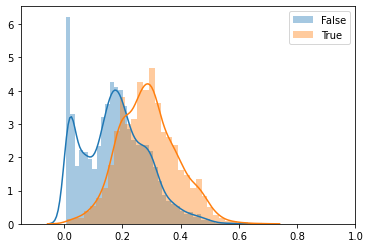

In [60]:
# sns.distplot(y_valid.astype(int), label='Original')
sns.distplot(y_preds['RF'][y_valid == False], label='False')
sns.distplot(y_preds['RF'][y_valid == True], label='True')
plt.xlim([-0.15, 1])
plt.legend();

## Interactions

We can see that many of the variables do not have a significant impact on the TARGET, however, it is possible that interacting with other variables may have significant predictive power. For this, what we will do is create interactions between the different variables and evaluate when the contribution is significant. An example of categorical interaction is `WEBSITE` which is the union of `WEB` + `COUNTRY`, i.e, EDES = ED + ES.

In [61]:
def create_interactions(df, features, type_='*'):
    interactions = pd.DataFrame(index=df.index)
    for col1, col2 in tqdm(it.combinations(features, 2)):
        new_col_name = '__'.join([col1, col2])
        if type_ == '+':
            interactions[new_col_name] = df[col1].values + df[col2].values
        elif type_ == '-':
            interactions[new_col_name] = df[col1].values - df[col2].values
        elif type_ == '*':
            interactions[new_col_name] = df[col1].values * df[col2].values
        elif type_ == '/':
            interactions[new_col_name] = df[col1].values / df[col2].values
        elif type_ == '__':
            # Convert to strings and combine
            new_values = df[col1].astype(str) + "_" + df[col2].astype(str)
            interactions[new_col_name] = new_values
        
        # Reduce memory in numeric features
        if type_ in ['+', '-', '*', '/']:
            if interactions[new_col_name].max() < 128: 
                interactions[new_col_name] = interactions[new_col_name].astype('int8')
            elif interactions[new_col_name].max() < 32768: 
                interactions[new_col_name] = interactions[new_col_name].astype('int16')
            else: interactions[new_col_name].astype('int32')
            
    baseline_data = df.join(interactions, sort=False)
    new_features = interactions.columns
    return baseline_data, new_features

In [62]:
cat_features = train.select_dtypes(exclude=['number', 'bool']).columns.drop(['DEPARTURE', 'ARRIVAL', 'WEBSITE'])
train_new2, new_features = create_interactions(train_new, cat_features, type_='__')
print(f'There are {len(new_features)} new features')
# df_cat_interactions = baseline_data2[new_features]


There are 28 new features


In [63]:
f = train_new2.columns.drop(to_drop).to_list()
y = train_new2[TARGET]
X = train_new2[f]

# Split data into train & validation
X_train, y_train, X_valid, y_valid = split_data(
    X, y, train_index, valid_index)

# Encode categorical variables
to_encode = X_train.select_dtypes(exclude=['number', 'bool']).columns.to_list()
encoder = ce.OrdinalEncoder(cols=to_encode, return_df=True)
X_train = encoder.fit_transform(X_train)
X_valid = encoder.fit_transform(X_valid)

In [64]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=9,
                             max_features='auto', criterion='entropy', n_jobs=-1) 
# class_weight='balanced'

# Evaluate results
cv_results = cross_validate(
    clf, X_train, y_train, scoring='roc_auc', cv=cv,
    return_train_score=True, return_estimator=True)
show_results(cv_results)
scores['RF_INT'] = (cv_results['train_score'], cv_results['test_score'])

# Make predictions using each estimator
y_oof = [estimator.predict_proba(X_valid)[:, 1] for estimator in cv_results['estimator']]
y_preds['RF_INT'] = np.mean(y_oof, axis=0)
# print(roc_auc_score(y_valid, y_preds['RF_INT']))

ROC AUC: 0.8511 || 0.7714 (+/- 0.01)


Categorical visualizations

In [65]:
# mask = importance.index.isin(new_features)
# importance[mask].sort_values('imp', ascending=False)

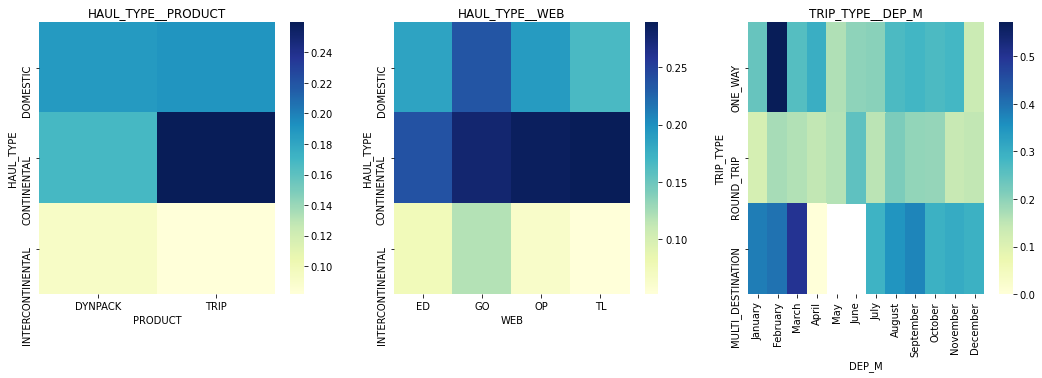

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

for i, f in enumerate(['HAUL_TYPE__PRODUCT', 'HAUL_TYPE__WEB', 'TRIP_TYPE__DEP_M']):
    x, y = f.split('__')
    tmp = train[[x, y, TARGET]]
    tmp = tmp.groupby([x, y])[TARGET].mean().reset_index().pivot(x, y, TARGET)
    ax = sns.heatmap(tmp, cmap="YlGnBu", ax=axs[i])
    ax.set_title(f)

## Encoding cyclical features

The difference in time between month 9 and 10 is of course 1  month. If we leave the month feature unencoded, everything works in this case: 10-9=1 month.  However, if we look at month 12 and 1 we see the failure in our encoding:  1−12=−11 months , even though the records are again only one month apart.

We need to change the encoding of the feature such that month 12 and 1 are the same distance apart as any other two months. A common method for encoding cyclical data is to transform the data into two dimensions using a sine and cosine transformation.

We can do that using the following transformations:

$$x_{\sin}=\sin\Big(\frac{2\pi x}{freq(x)}\Big)$$

$$x_{\cos}=\cos\Big(\frac{2\pi x}{freq(x)}\Big)$$

In [67]:
def CyclicalEncoder(df, col, freq=12., drop=False):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/freq)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/freq)
    if drop: df.drop(col, axis=1, inplace=True)
    return df

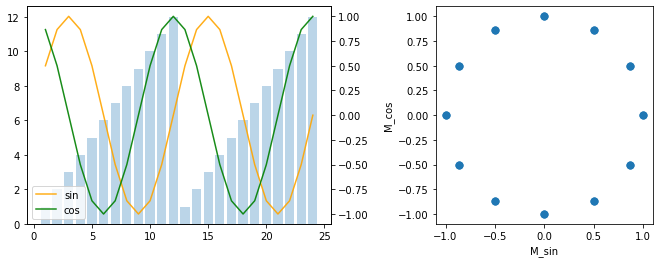

In [68]:
# Encode cyclical features
months = list(range(1, 13)) + list(range(1, 13))
months = pd.DataFrame({'M': months})
months = CyclicalEncoder(months, 'M', 12.)
months.index = months.index + 1
f, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(months.index, months['M'], alpha=0.3)
axs[0] = axs[0].twinx()
axs[0].plot(months.index, months['M_sin'], color='orange', alpha=0.9, label='sin')
axs[0].plot(months.index, months['M_cos'], color='green', alpha=0.9, label='cos')
axs[0].legend();
months.plot.scatter('M_sin', 'M_cos', s=50, ax=axs[1]).set_aspect('equal')

In [69]:
X_train = CyclicalEncoder(X_train, 'DEP_D', 31., drop=False)
X_train = CyclicalEncoder(X_train, 'DEP_M', 12., drop=False)
X_train = CyclicalEncoder(X_train, 'DEP_Q', 4.,  drop=False)
X_valid = CyclicalEncoder(X_valid, 'DEP_D', 31., drop=False)
X_valid = CyclicalEncoder(X_valid, 'DEP_M', 12., drop=False)
X_valid = CyclicalEncoder(X_valid, 'DEP_Q', 4.,  drop=False)

Cyclical features does not improve our Random Forest model. Maybe they work better in linear models because there is a kind of normalization. Furthermore, two new features are created for every one, so we are increasing the size of the data set and this may affect (despite it should not).

In [70]:
# Evaluate results
cv_results = cross_validate(
    clf, X_train, y_train, scoring='roc_auc', cv=cv,
    return_train_score=True, return_estimator=True)
show_results(cv_results)
scores['RF_CYCLE'] = (cv_results['train_score'], cv_results['test_score'])

# Make predictions using each estimator
y_oof = [estimator.predict_proba(X_valid)[:, 1] for estimator in cv_results['estimator']]
y_preds['RF_CYCLE'] = np.mean(y_oof, axis=0)

ROC AUC: 0.8528 || 0.7704 (+/- 0.01)


In [71]:
# Drop features because they have not increase the CV score
for c in ['DEP_D', 'DEP_M', 'DEP_Q']:
    X_train.drop([c+'_sin'], axis=1, inplace=True)
    X_train.drop([c+'_cos'], axis=1, inplace=True)
    X_valid.drop([c+'_sin'], axis=1, inplace=True)
    X_valid.drop([c+'_cos'], axis=1, inplace=True)

# Feature Selection

Feature selection is important because we want to improve the computational efficiency of our models and reduce the generalization error by removing irrelevant features. Exist different ways to do that:

* **Forward selection**: add *n* features at time based on the classifier performance until a feature subset of the desired size is reached
* **Backward selection**: start with the complete dataset and remove *n* variables until the desired size is reached
* **Model selection**: Use the coefficients of the model to identify the most important features

There exist other methods as well

## Sequential Forward Selection 

In [72]:
clf = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=9,
                             max_features='auto', criterion='entropy', n_jobs=-1)

In [73]:
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# sfs1 = SFS(clf, 
#            k_features=110, 
#            forward=True, 
#            floating=False, 
#            verbose=2,
#            scoring='roc_auc',
#            cv=cv)
# sfs1 = sfs1.fit(X_train, y_train)
# pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

In [74]:
# fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
# plt.ylim([0.75, 0.79])
# plt.title('Sequential Forward Selection (w. StdDev)')
# plt.grid()
# plt.show()

In [75]:
# # sfs1.k_feature_names_
# selected_features = ['INFANTS',
#  'TRAIN',
#  'DEVICE',
#  'PRODUCT',
#  'NO_GDS',
#  'WEB',
#  'DAYS_TO_FLIGHT',
#  'TRIP_DAYS',
#  'PASSENGERS',
#  'TOTAL_FLIGHTS',
#  'WEBSITE_DEVICE_nunique',
#  'DISTANCE_HAUL_TYPE_WEBSITE_DEVICE_nunique',
#  'HAUL_TYPE_TRIP_TYPE_nunique',
#  'DISTANCE_HAUL_TYPE_TRIP_TYPE_nunique',
#  'DISTANCE_HAUL_TYPE_WEBSITE_TRIP_TYPE_nunique',
#  'HAUL_TYPE_PRODUCT_nunique',
#  'DISTANCE_HAUL_TYPE_WEBSITE_PRODUCT_nunique',
#  'HAUL_TYPE_COUNTRY_nunique',
#  'DISTANCE_HAUL_TYPE_WEB_nunique',
#  'DISTANCE_HAUL_TYPE_WEBSITE_WEB_nunique',
#  'DISTANCE_FE',
#  'HAUL_TYPE_FE',
#  'WEBSITE_FE',
#  'TRIP_TYPE_FE',
#  'PRODUCT_FE',
#  'COUNTRY_FE',
#  'WEBSITE_EXTRA_BAGGAGE_mean',
#  'WEBSITE_EXTRA_BAGGAGE_std',
#  'DISTANCE_HAUL_TYPE_ADULTS_std',
#  'DISTANCE_HAUL_TYPE_CHILDREN_mean',
#  'DISTANCE_HAUL_TYPE_NO_GDS_mean',
#  'DISTANCE_HAUL_TYPE_NO_GDS_std',
#  'DISTANCE_HAUL_TYPE_SMS_mean',
#  'DISTANCE_HAUL_TYPE_SMS_std',
#  'DISTANCE_HAUL_TYPE_ADULTS_RATIO_std',
#  'DISTANCE_HAUL_TYPE_TRIP_DAYS_mean',
#  'DISTANCE_HAUL_TYPE_TRIP_DAYS_std',
#  'DISTANCE_HAUL_TYPE_PASSENGERS_mean',
#  'DISTANCE_HAUL_TYPE_TOTAL_FLIGHTS_std',
#  'HAUL_TYPE__TRIP_TYPE',
#  'HAUL_TYPE__PRODUCT',
#  'HAUL_TYPE__WEB',
#  'HAUL_TYPE__COUNTRY',
#  'DEVICE__TRIP_TYPE',
#  'DEVICE__PRODUCT',
#  'DEVICE__WEB',
#  'TRIP_TYPE__WEB',
#  'TRIP_TYPE__DEP_Q',
#  'PRODUCT__COUNTRY',
#  'COUNTRY__DEP_M']

## Recursive Feature Elimination
Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [76]:
# selector = RFECV(clf, step=1, cv=cv, scoring='roc_auc', verbose=2, n_jobs=1)
# selector = selector.fit(X_train, y_train)

In [77]:
# # Plot number of features VS. cross-validation scores
# print("Optimal number of features : %d" % selector.n_features_)
# plt.figure(figsize=(8, 6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
# plt.show()

In [78]:
# selected_features = X_train.iloc[:, selector.support_].columns
# selected_features

In [79]:
selected_features = ['GDS', 'ADULTS', 'TRIP_TYPE', 'NO_GDS', 'COUNTRY', 'DAYS_TO_FLIGHT',
       'TRIP_DAYS', 'IS_SAME_DAY', 'DEP_D', 'PASSENGERS', 'TOTAL_FLIGHTS',
       'DISTANCE_HAUL_TYPE_WEBSITE_DEVICE_nunique',
       'HAUL_TYPE_COUNTRY_nunique', 'DISTANCE_COUNTRY_nunique',
       'DISTANCE_HAUL_TYPE_COUNTRY_nunique', 'DISTANCE_FE', 'HAUL_TYPE_FE',
       'WEBSITE_FE', 'TRIP_TYPE_FE', 'COUNTRY_FE', 'WEB_FE',
       'HAUL_TYPE_EXTRA_BAGGAGE_mean', 'HAUL_TYPE_EXTRA_BAGGAGE_std',
       'WEBSITE_EXTRA_BAGGAGE_mean', 'WEBSITE_EXTRA_BAGGAGE_std',
       'DISTANCE_HAUL_TYPE_ADULTS_mean', 'DISTANCE_HAUL_TYPE_ADULTS_std',
       'DISTANCE_HAUL_TYPE_CHILDREN_mean', 'DISTANCE_HAUL_TYPE_CHILDREN_std',
       'DISTANCE_HAUL_TYPE_GDS_mean', 'DISTANCE_HAUL_TYPE_GDS_std',
       'DISTANCE_HAUL_TYPE_NO_GDS_mean', 'DISTANCE_HAUL_TYPE_NO_GDS_std',
       'DISTANCE_HAUL_TYPE_SMS_mean', 'DISTANCE_HAUL_TYPE_SMS_std',
       'DISTANCE_HAUL_TYPE_ADULTS_RATIO_mean',
       'DISTANCE_HAUL_TYPE_ADULTS_RATIO_std',
       'DISTANCE_HAUL_TYPE_TRIP_DAYS_mean', 'DISTANCE_HAUL_TYPE_TRIP_DAYS_std',
       'DISTANCE_HAUL_TYPE_PASSENGERS_mean',
       'DISTANCE_HAUL_TYPE_PASSENGERS_std',
       'DISTANCE_HAUL_TYPE_TOTAL_FLIGHTS_mean',
       'DISTANCE_HAUL_TYPE_TOTAL_FLIGHTS_std',
       'DISTANCE_HAUL_TYPE_IS_SAME_DAY_mean',
       'DISTANCE_HAUL_TYPE_IS_SAME_DAY_std', 'HAUL_TYPE__DEVICE',
       'HAUL_TYPE__TRIP_TYPE', 'HAUL_TYPE__PRODUCT', 'HAUL_TYPE__WEB',
       'HAUL_TYPE__COUNTRY', 'HAUL_TYPE__DEP_M', 'HAUL_TYPE__DEP_Q',
       'DEVICE__TRIP_TYPE', 'DEVICE__WEB', 'DEVICE__COUNTRY', 'DEVICE__DEP_M',
       'TRIP_TYPE__PRODUCT', 'TRIP_TYPE__WEB', 'TRIP_TYPE__COUNTRY',
       'TRIP_TYPE__DEP_M', 'TRIP_TYPE__DEP_Q', 'PRODUCT__WEB',
       'PRODUCT__COUNTRY', 'WEB__COUNTRY', 'WEB__DEP_M', 'WEB__DEP_Q',
       'COUNTRY__DEP_M', 'COUNTRY__DEP_Q']

# Modeling

When considering ensemble learning, there are two primary methods: bagging and boosting. Bagging involves the training of many independent models and combines their predictions through some form of aggregation. An example of a bagging ensemble is a Random Forest.

Boosting instead trains models sequentially, where each model learns from the errors of the previous model. Starting with a weak base model, models are trained iteratively, each adding to the prediction of the previous model to produce a strong overall prediction.

## Random Forest

Random forest is an improved version of the bagged trees, because they create multiple uncorrelated trees to reduce the variance. In addition, they are simpler than the famous XGBoost or LightGBM, making it easier to tune the parameters and understand what is happening under the hood.

In [80]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=9,
                             max_features='auto', criterion='entropy', n_jobs=-1) #class_weight='balanced'

# Evaluate results
cv_results = cross_validate(
    clf, X_train[selected_features], y_train, scoring='roc_auc', cv=cv,
    return_train_score=True, return_estimator=True)
show_results(cv_results)
scores['RF_RFE'] = (cv_results['train_score'], cv_results['test_score'])

# Make predictions using each estimator
y_oof = [estimator.predict_proba(X_valid[selected_features])[:, 1] for estimator in cv_results['estimator']]
y_oof = np.mean(y_oof, axis=0)
y_preds['RF_RFE'] = y_oof
# print(roc_auc_score(y_valid, y_preds['RF_RFE']))

ROC AUC: 0.8530 || 0.7728 (+/- 0.01)


## Tunning hyper parameters

The following parameters are usually tuned:

* **n_estimators**: The number of trees in the forest.
* **max_features**: number of variables to randomly sample as candidates as each split
* **min_samples_leaf**: number of minimum samples within the terminal nodes. Smaller node size allows for deeper, more complex trees.
* **min_samples_split**: minimum number of data points placed in a node before the node is split

In [81]:
# Set up possible values of parameters to optimize over
p_grid = {
    'n_estimators': [50],
    'max_features': ['auto'],  
    'min_samples_leaf': [5, 7],
    'max_depth': [7, 11],
    'min_samples_split': [9, 11]
}

# GridSeach parameter optimization
grid = GridSearchCV(estimator=clf, param_grid=p_grid, cv=cv, iid=False,
                    scoring='roc_auc', n_jobs=1, return_train_score=True,
                    refit=False)
grid = grid.fit(X_train[selected_features], y_train)
print("ROC AUC: %0.4f || %0.4f" % 
  (grid.cv_results_['mean_train_score'][grid.best_index_], 
   grid.cv_results_['mean_test_score'][grid.best_index_]))
print(f'Best params: {grid.best_params_}')

ROC AUC: 0.8935 || 0.7794
Best params: {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 50}


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [82]:
# Cross validate best model
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=11,
                             min_samples_leaf=5, min_samples_split=9,
                             max_features='auto', criterion='entropy', 
                             n_jobs=-1)

# Evaluate results
cv_results = cross_validate(
    clf, X_train[selected_features], y_train, scoring='roc_auc', cv=cv,
    return_train_score=True, return_estimator=True)
show_results(cv_results)
scores['Grid_RF'] = (cv_results['train_score'], cv_results['test_score'])

# Make predictions using each estimator
y_oof = [estimator.predict_proba(X_valid[selected_features])[:, 1] for estimator in cv_results['estimator']]
y_oof = np.mean(y_oof, axis=0)
y_preds['Grid_RF'] = y_oof

ROC AUC: 0.8946 || 0.7782 (+/- 0.01)


## LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. 

Some of the most important parameters are:
* **num_leaves**: this is the main parameter to control the complexity of the tree mode
* **min_data_in_leaf**: parameter to prevent over-fitting in a tree. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
* **learning_rate**: how much the algorithm can learn in each iteration
* **feature_fraction**: randomly select part of features on each iteration (tree). For example, if is set to 0.9, LightGBM will select 90% of features before training each tree
* **bagging_fraction**: percentage of rows without resampling thateach tree will randomly select

In [83]:
param = {
    'num_leaves': 2048, #50,
    'min_data_in_leaf': 30,
    'objective': 'binary',
    'max_depth': 5,
    'learning_rate': 0.1,
    'boosting': "gbdt",
    'feature_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'bagging_seed': 44,
    'metric': 'auc',
    'verbosity': 1 }

y_oof = np.zeros_like(y_valid.values)
cvg2 = GroupKFold(n_splits=5)
train_arr = np.zeros(5)
valid_arr = np.zeros(5)
# for i, (trn_idx, val_idx) in enumerate(cvg2.split(X_train, y_train, cv_groups)):
for i, (trn_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f'Fold {i+1}')
    X_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    dtrain = lgb.Dataset(X_trn[selected_features], label=y_trn)
    dtest = lgb.Dataset(X_val[selected_features], label=y_val)

    # Train the model
    num_round = 500
    clf = lgb.train(param, dtrain, num_round,
        valid_sets=[dtrain, dtest],
        valid_names=['train', 'valid'],
        verbose_eval=20,
        early_stopping_rounds=50)
    # Store metrics
    train_arr[i] = clf.best_score['train']['auc']
    valid_arr[i] = clf.best_score['valid']['auc']
    # Predict on validation
    y_oof = y_oof + clf.predict(X_valid[selected_features])

# Save scores and predictions 
scores['LGB'] = (train_arr, valid_arr)
y_preds['LGB'] = y_oof / cvg2.get_n_splits()

Fold 1
Training until validation scores don't improve for 50 rounds
[20]	train's auc: 0.791459	valid's auc: 0.762288
[40]	train's auc: 0.806325	valid's auc: 0.768888
[60]	train's auc: 0.821168	valid's auc: 0.77284
[80]	train's auc: 0.833269	valid's auc: 0.775727
[100]	train's auc: 0.842374	valid's auc: 0.776433
[120]	train's auc: 0.851813	valid's auc: 0.778704
[140]	train's auc: 0.860241	valid's auc: 0.779371
[160]	train's auc: 0.868885	valid's auc: 0.781125
[180]	train's auc: 0.876029	valid's auc: 0.782408
[200]	train's auc: 0.881872	valid's auc: 0.782705
[220]	train's auc: 0.887651	valid's auc: 0.783738
[240]	train's auc: 0.892966	valid's auc: 0.784366
[260]	train's auc: 0.899075	valid's auc: 0.784143
[280]	train's auc: 0.903164	valid's auc: 0.784355
[300]	train's auc: 0.908345	valid's auc: 0.786245
[320]	train's auc: 0.911782	valid's auc: 0.785961
[340]	train's auc: 0.915801	valid's auc: 0.786023
[360]	train's auc: 0.920262	valid's auc: 0.785968
Early stopping, best iteration is:
[3

# Model comparison
So far, several models have been trained using different sets of features and algorithms (Random Forest and LightGBM). Now let's summarize all the training information and determine which one is the best.

We will start by visualizing a summary table of the metrics obtained by the models during the cross validation in such a way that it will be easy for us to quickly see which model has been the best. In addition, a graph will be shown to being able to see the average  and the dispersion of the models.

In the next section, we will explain which metrics are commonly used in classification problems and why we should use them instead of accuracy.

## Cross validation scores

In [84]:
# table = {k: np.mean(v, axis=1) for k, v in scores.items()}
# pd.DataFrame.from_dict(table, orient='index', columns=['Train', 'Test']
#                       ).sort_values(by='Test', ascending=False).round(3)

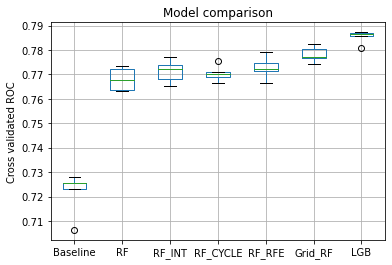

In [85]:
# Visualize all models
table = {k: v[1] for k, v in scores.items()}
ax = pd.DataFrame.from_dict(table).boxplot()
ax.set_title('Model comparison')
ax.set_ylabel('Cross validated ROC')
plt.show()

It seems that `LGB` and the Random Forest after hyper parameter tunning, `Grid_RF`, are the best models. But can we say that `LGB` is better than `Grid_RF` or it has been by chance? In order to show how we can check if one model is better than the other, let's check if the `LGB` model is better than the `Grid_RF`. Given the results of the `t-test` we are 95% confident that the `LGB` model is better than the `Grid_RF` but it should be noted that, as we only have 5 values (models have been trained using 5 folds), the test is not reliability.

In [86]:
s1 = scores['Grid_RF'][1]
s2 = scores['LGB'][1]
_, p, improvement = compare_models_1way(s1, s2)
print(f'T-test pvalue: {p:.3f}')

T-test pvalue: 0.011


## What metric should we use?
The first measure that comes to my mind is accuracy because it measures the percentage of total observations classified correctly, but there exist other metrics that can gives us a better perfespective of how precise is the algorithm. Some of them are *precision* (false positives, type error I) and *recall* (false negatives, type error II). In plain english:

* $Precision = \dfrac{T_P}{T_P + F_P}$: for all instances classified positive, what percent was correct?
* $Recall = \dfrac{T_P}{T_P + F_N}$: for all instances that were actually positive, what percent was classified correctly?

A way to relate precision and recall is using $F_1$ score, the weighted average of the precision and recall. Another interesting metric to look at is *specificity* that tell us how good is the model predicting 0’s. Why we could be interested in this metrics?

Let's look at an example to better understand how metrics work. Using this dataset, if the algorithm predicted all 0's we would obtain an accuracy of 80%, a precision of 100% and a recall of 0%. Likewise, if the algorithm predicted all 1's we would obtain an accuracy of 20%, a precision of 0% and a recall of 100% (it would be capturing all the positive cases). So, despite the high accuracy of the first case the model would not be useful.

As we have seen when our datatset is imbalanced, accuracy does not work well and we would need look at other metrics. A common way to analyze the performance of a model is using the ROC (receiver operating characteristic) curve because it show us information about true positive rate and false negative rate, allows optimize models before the definition of a threshold and can be used to pick an optimal cutoff based on the trade-off between the types of errors.

When the dataset is highly imbalanced ROC can lead us to overoptimistic results, in such cases is always a good idea combine ROC with precision - recall curves.

In [87]:
def plot_metrics(y, y_pred_dict):
    f, axs = plt.subplots(1, 2, figsize=(12, 6))
    # ROC Curve
    for k, y_pred in y_pred_dict.items():
        roc = roc_auc_score(y, y_pred)
        fpr, tpr, thresholds = roc_curve(y, y_pred)
        axs[0].plot(fpr, tpr, linestyle='--', label=f'{k}={roc:.2f}')
        axs[0].plot([0, 1], [0, 1], 'k--', alpha=0.2)
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].set_title('Receiver Operating Characteristic')
        axs[0].legend()
        
    # Precision/recall curve
    for k, y_pred in y_pred_dict.items():    
        # calculate precision and recall for each threshold
        precision, recall, _ = precision_recall_curve(y, y_pred)
        
        fpr, tpr, thresholds = roc_curve(y, y_pred)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        # plot the precision-recall curves
        axs[1].plot(recall, precision, linestyle='--', label=f'{k}={optimal_threshold:.2f}')
        axs[1].plot([0, 1], [1, 0], 'k--', alpha=0.2)
        axs[1].set_xlabel(r'Recall')
        axs[1].set_ylabel(r'Precision')
        axs[1].set_title('Precision/Recall curves')
        axs[1].legend()
    
    plt.show()

The top left corner of the ROC plot is the ideal point - a false positive rate of zero, and a true positive rate of one. Regarding the precision/recall curves the top right corner is the ideal point with high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

$$TPR = \dfrac{T_P}{T_P + F_N}$$

$$FPR = \dfrac{F_P}{F_P + T_N}$$

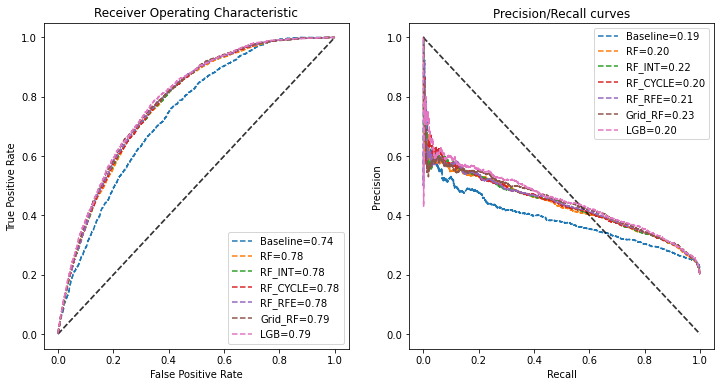

In [88]:
plot_metrics(y_valid, y_preds)

In [89]:
# Given tpr, fpr, thresholds from your question, the answer for the optimal threshold is just:
model = 'LGB'
fpr, tpr, thresholds = roc_curve(y_valid, y_preds[model])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold.round(4))

0.1969


In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_preds[model] > optimal_threshold))

              precision    recall  f1-score   support

       False       0.92      0.66      0.77      9534
        True       0.36      0.78      0.50      2378

    accuracy                           0.68     11912
   macro avg       0.64      0.72      0.63     11912
weighted avg       0.81      0.68      0.72     11912



# Ensemble

Ensembles are combinations of models. Generally, as more diverse and different models the best are the results are obtained. As an example, we are going to combine the predictions of some of the models seen so far to see if they increase the ROC.

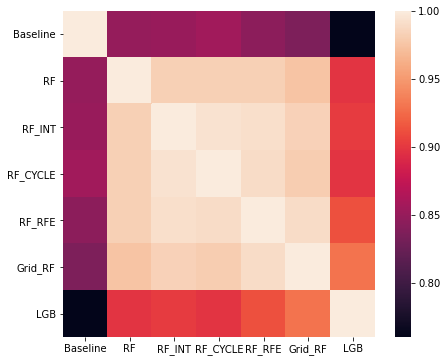

In [91]:
models_corr = pd.DataFrame.from_dict(y_preds).corr()
plt.figure(figsize=(7, 6))
sns.heatmap(models_corr)
plt.show()

In [92]:
# # Correlation esemble
y_preds_2 = y_preds.copy()
y_preds_2['Ensemble'] = (y_preds['Grid_RF'] + y_preds['LGB']) / 2.
print(f'ROC Grid_RF: {roc_auc_score(y_valid, y_preds_2["Grid_RF"]):.3f}')
print(f'ROC LGB: {roc_auc_score(y_valid, y_preds_2["LGB"]):.3f}')
print(f'ROC Ensemble: {roc_auc_score(y_valid, y_preds_2["Ensemble"]):.3f}')

ROC Grid_RF: 0.786
ROC LGB: 0.789
ROC Ensemble: 0.791


# Predicting test set

To predict the test set we must re-create all the features that we have created before. During the training phase we have used all the data available to create Feature Encodings and aggregations, so that to make predictions we must do exactly the same that we did before. First, the train and test will be joined, then all the features will be created again and finally, the predictions will be done.

In [93]:
def concat_train_test(train, test):
    # Combine train and test to pre-process data
    n_train = len(train)
    train_test = pd.concat([train, test], axis=0, sort=False)
    train_test = train_test.reset_index(drop=True)
    train_test[TARGET] = train_test[TARGET].astype(bool)
    return train_test, n_train

In [94]:
# Merge train and test and create new features
train_test, n_train = concat_train_test(train, test)
train_test = CreateAggregations(train_test)
train_test, new_features = create_interactions(train_test, cat_features, type_='__')
print(f'There are {len(new_features)} new features')


There are 28 new features


In [95]:
# Select columns
f = train_test.columns.drop([TARGET, 'DEPARTURE', 'ARRIVAL']).to_list()
y = train_test[TARGET]
X = train_test[f]

# Split data into train & validation
train_ = train_test[:n_train]
test_  = train_test[:n_train]
cv_groups2 = train_['DISTANCE']

X_train, y_train = train_[selected_features], train_[TARGET]
X_test, y_test = test_[selected_features], test_[TARGET]

# Encode categorical variables
to_encode = X_train.select_dtypes(exclude=['number', 'bool']).columns.to_list()
encoder = ce.OrdinalEncoder(cols=to_encode, return_df=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

In [96]:
y_oof = np.zeros_like(y_test.values)
for i, (trn_idx, val_idx) in enumerate(cvg2.split(X_train, y_train, cv_groups2)):
    print(f'Fold {i+1}')
    X_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_trn[selected_features], label=y_trn)
    dtest = lgb.Dataset(X_val[selected_features], label=y_val)

    # Train the model
    num_round = 500
    clf = lgb.train(param, dtrain, num_round,
        valid_sets=[dtrain, dtest],
        valid_names=['train', 'valid'],
        verbose_eval=20,
        early_stopping_rounds=50)
    
    # Predict on test set
    y_oof = y_oof + clf.predict(X_test[selected_features])

# Save predictions
y_test = y_oof / cvg2.get_n_splits()

Fold 1
Training until validation scores don't improve for 50 rounds
[20]	train's auc: 0.790132	valid's auc: 0.770892
[40]	train's auc: 0.804676	valid's auc: 0.775859
[60]	train's auc: 0.816406	valid's auc: 0.77712
[80]	train's auc: 0.827405	valid's auc: 0.77744
[100]	train's auc: 0.83749	valid's auc: 0.777774
[120]	train's auc: 0.844882	valid's auc: 0.777015
[140]	train's auc: 0.851893	valid's auc: 0.776221
Early stopping, best iteration is:
[99]	train's auc: 0.837205	valid's auc: 0.777782
Fold 2
Training until validation scores don't improve for 50 rounds
[20]	train's auc: 0.791391	valid's auc: 0.760754
[40]	train's auc: 0.807263	valid's auc: 0.767215
[60]	train's auc: 0.817936	valid's auc: 0.767872
[80]	train's auc: 0.827895	valid's auc: 0.768511
[100]	train's auc: 0.836262	valid's auc: 0.76881
[120]	train's auc: 0.844589	valid's auc: 0.767771
[140]	train's auc: 0.852342	valid's auc: 0.766388
Early stopping, best iteration is:
[98]	train's auc: 0.835785	valid's auc: 0.76884
Fold 3
Tr

In [97]:
submission = pd.DataFrame()
submission[TARGET] = y_test
submission.to_csv('submission.csv')
submission.head()

,EXTRA_BAGGAGE
0,0.090301
1,0.142652
2,0.215443
3,0.216535
4,0.348563


# Thing that doesn't work

* Feature selection with lasso
* Downsampling and SMOTE resampling techniques
* Use of weights in Random Forest
* Use of cyclical features
* Use of PCA for dimensionality reduction